
Top correlated inputs for Out1:
IN1     0.624829
 IN3    0.572199
 IN5    0.428711
 IN2    0.388346
 IN4    0.301107
Name: Out1, dtype: float64

Top correlated inputs for Out2:
 IN3    0.415136
IN1     0.381853
 IN4    0.203665
 IN2    0.201564
 IN5    0.101761
Name: Out2, dtype: float64


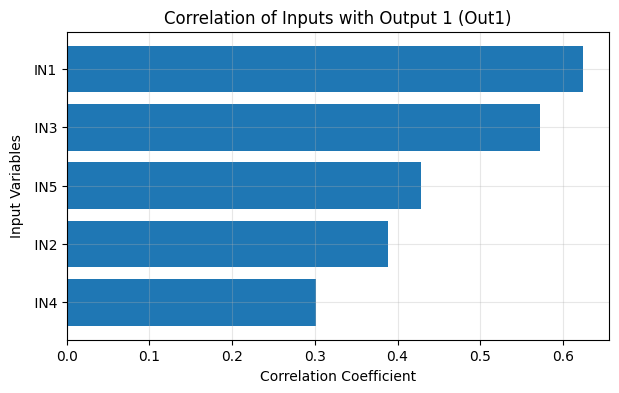

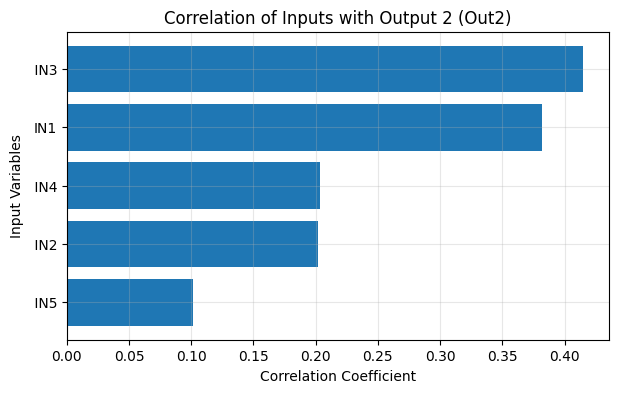

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# data loading
df_in = pd.read_csv("IN_Table.csv")
df_out = pd.read_csv("OUT_Table.csv")

# correlation computation
corr_results = {}

for target in ["Out1", "Out2"]:
    df_temp = pd.concat([df_in, df_out[target]], axis=1)
    corr = df_temp.corr()[target].drop(target)

    # Store sorted correlations
    corr_results[target] = corr.abs().sort_values(ascending=False)

    print(f"\nTop correlated inputs for {target}:")
    print(corr_results[target].head(5))


# PREPARATION OF PLOT VALUES
inputs_out1 = corr_results["Out1"].head(5).index.tolist()
corr_out1   = corr_results["Out1"].head(5).values.tolist()

inputs_out2 = corr_results["Out2"].head(5).index.tolist()
corr_out2   = corr_results["Out2"].head(5).values.tolist()


# OUT1 PLOT
plt.figure(figsize=(7,4))
plt.barh(inputs_out1, corr_out1)
plt.title("Correlation of Inputs with Output 1 (Out1)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Input Variables")
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()


# OUT2 PLOT
plt.figure(figsize=(7,4))
plt.barh(inputs_out2, corr_out2)
plt.title("Correlation of Inputs with Output 2 (Out2)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Input Variables")
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()


 PROCESSING TARGET: Out1

 MODEL: Correlation (1st Order)  |  TARGET: Out1
 Train R2 : 0.4285
 Test R2  : 0.4598
 RMSE     : 0.7348
 SSE      : 2332.7981
 AIC      : -2651.5439
 BIC      : -2613.3165
Saved plot: Out1Correlation(1stOrder)_Analysis.png

 MODEL: Correlation (2nd Order)  |  TARGET: Out1
 Train R2 : 0.4774
 Test R2  : 0.5039
 RMSE     : 0.7041
 SSE      : 2142.4275
 AIC      : -2989.3860
 BIC      : -2855.5900
Saved plot: Out1Correlation(2ndOrder)_Analysis.png

 MODEL: Forward Selection (1st Order)  |  TARGET: Out1
 Train R2 : 0.4278
 Test R2  : 0.4591
 RMSE     : 0.7352
 SSE      : 2335.8002
 AIC      : -2647.9867
 BIC      : -2616.1305
Saved plot: Out1ForwardSelection(1stOrder)_Analysis.png

 MODEL: Forward Selection (2nd Order)  |  TARGET: Out1
 Train R2 : 0.4515
 Test R2  : 0.4749
 RMSE     : 0.7244
 SSE      : 2267.4391
 AIC      : -2756.3355
 BIC      : -2660.7669
Saved plot: Out1ForwardSelection(2ndOrder)_Analysis.png

 MODEL: Lasso (1st Order)  |  TARGET: Out1
 Tra

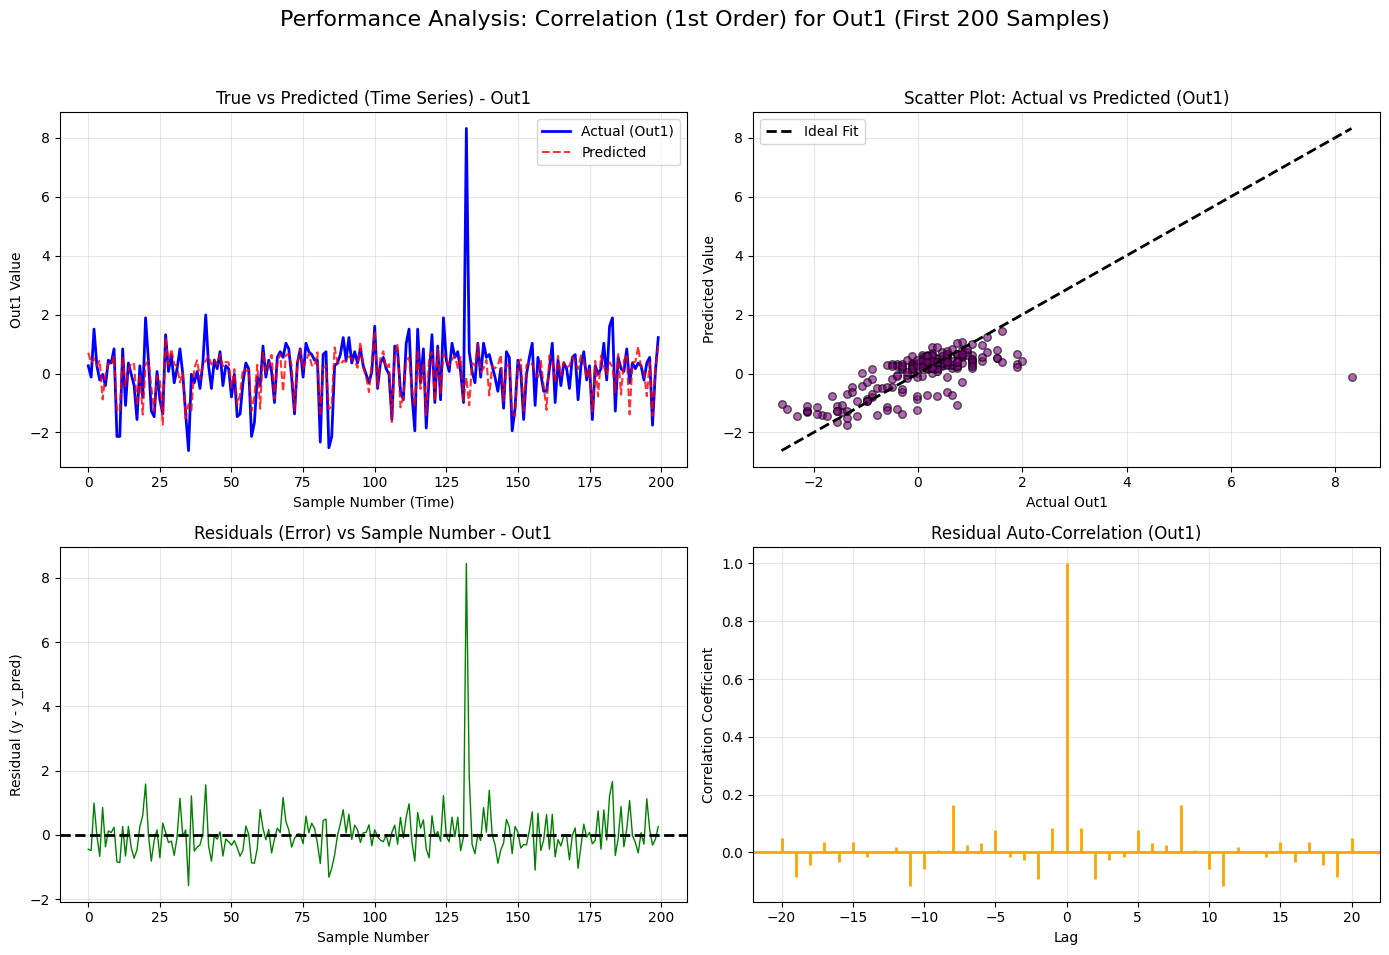

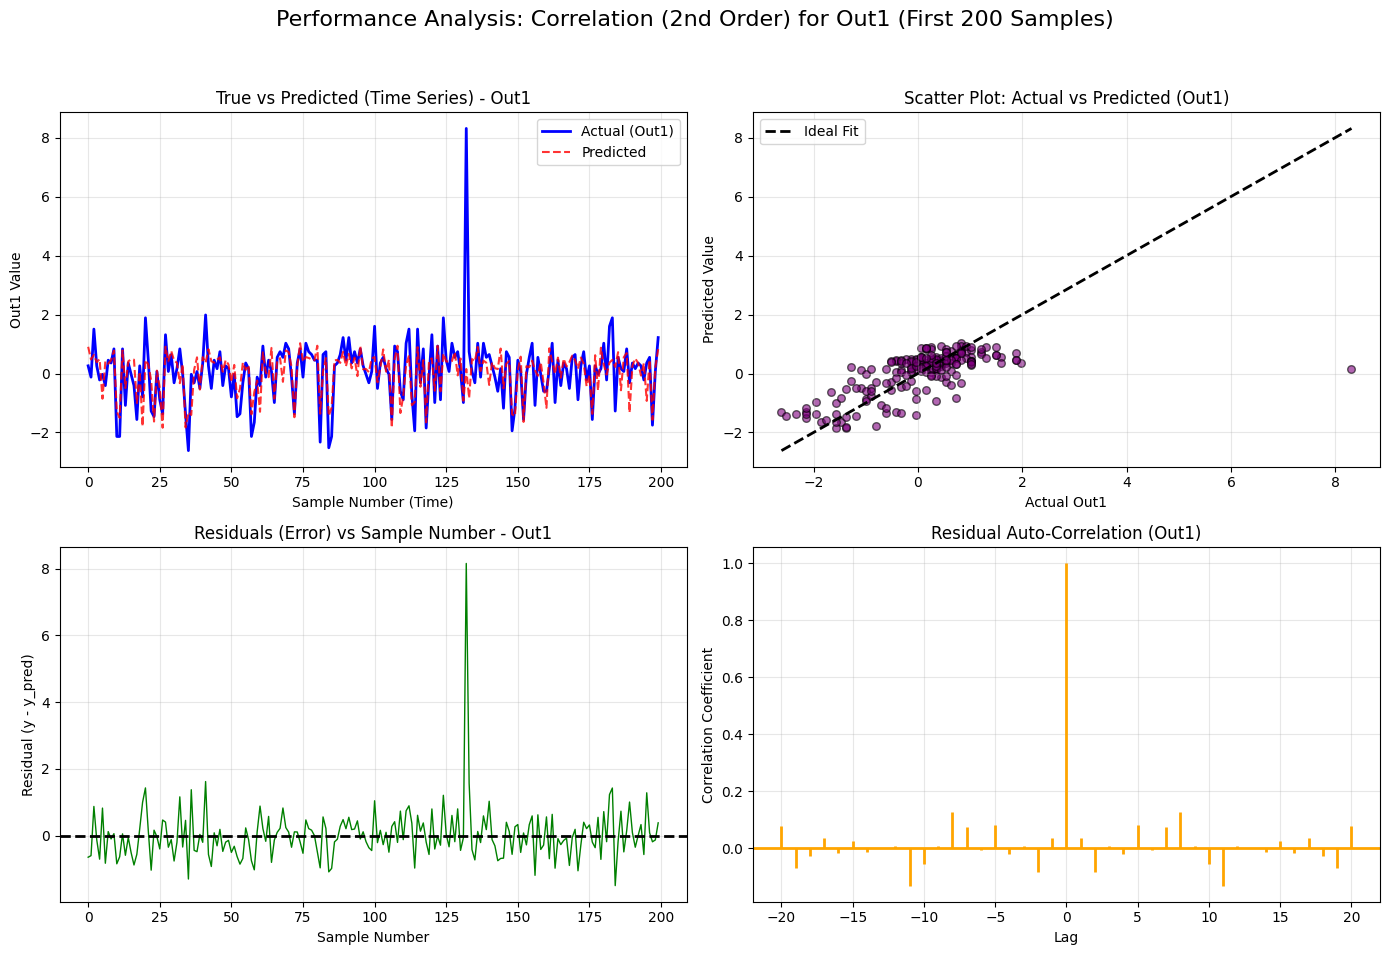

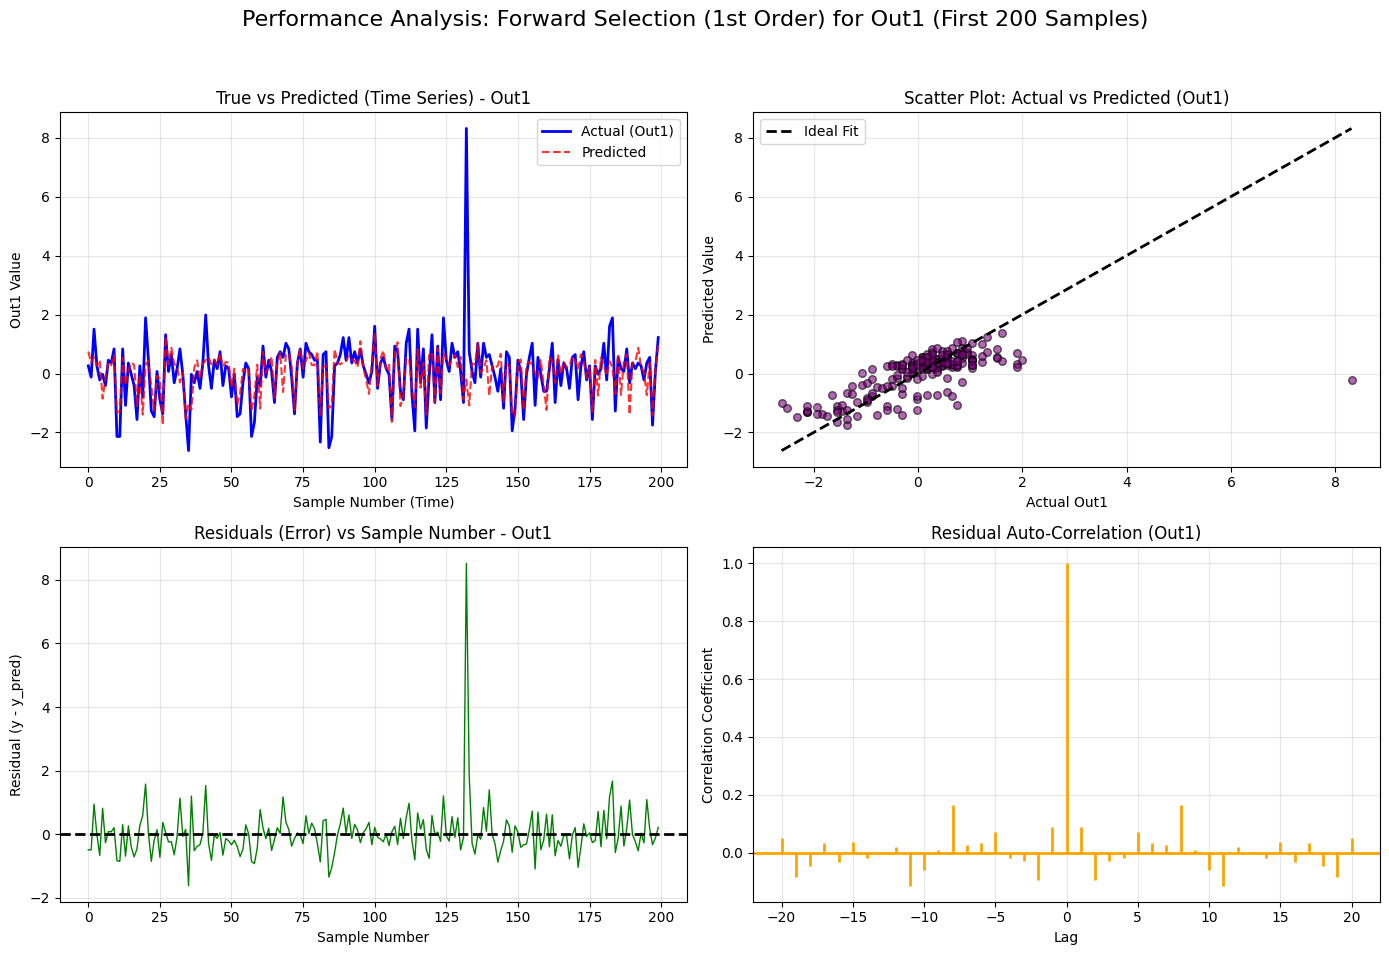

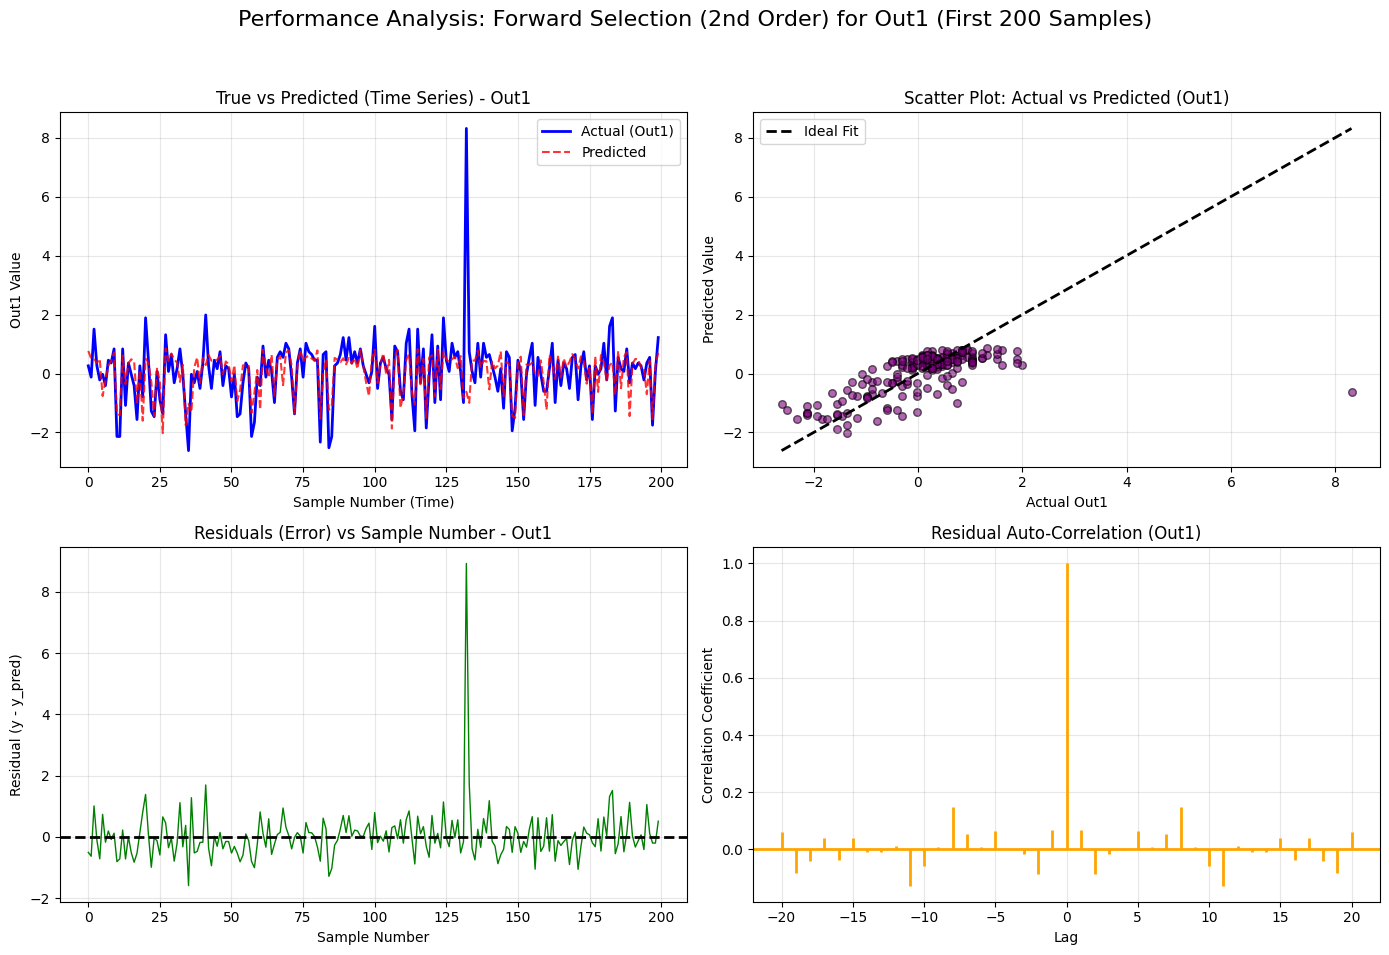

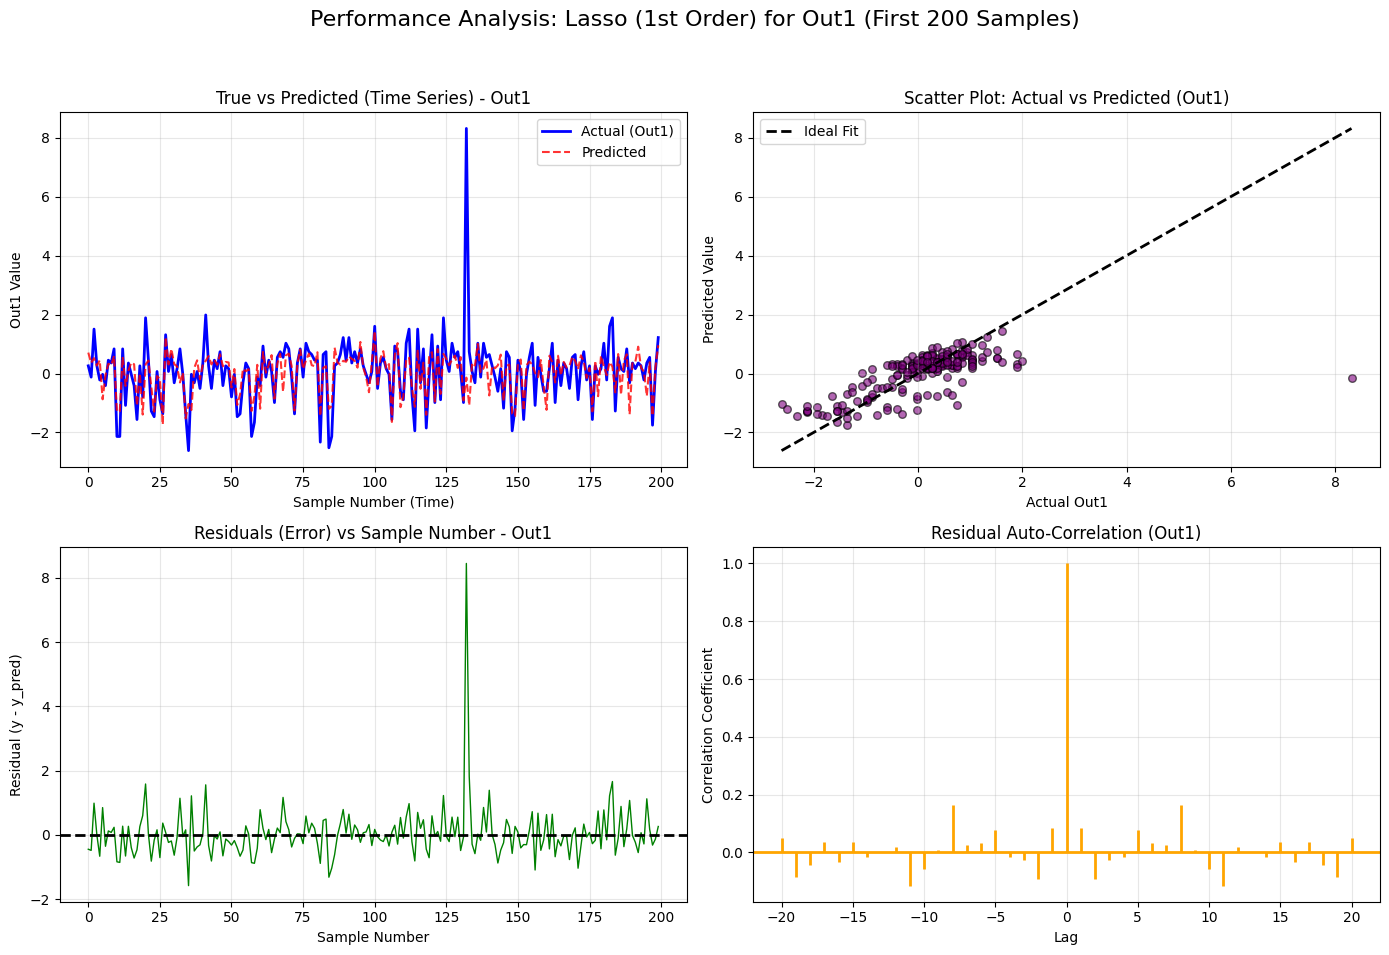

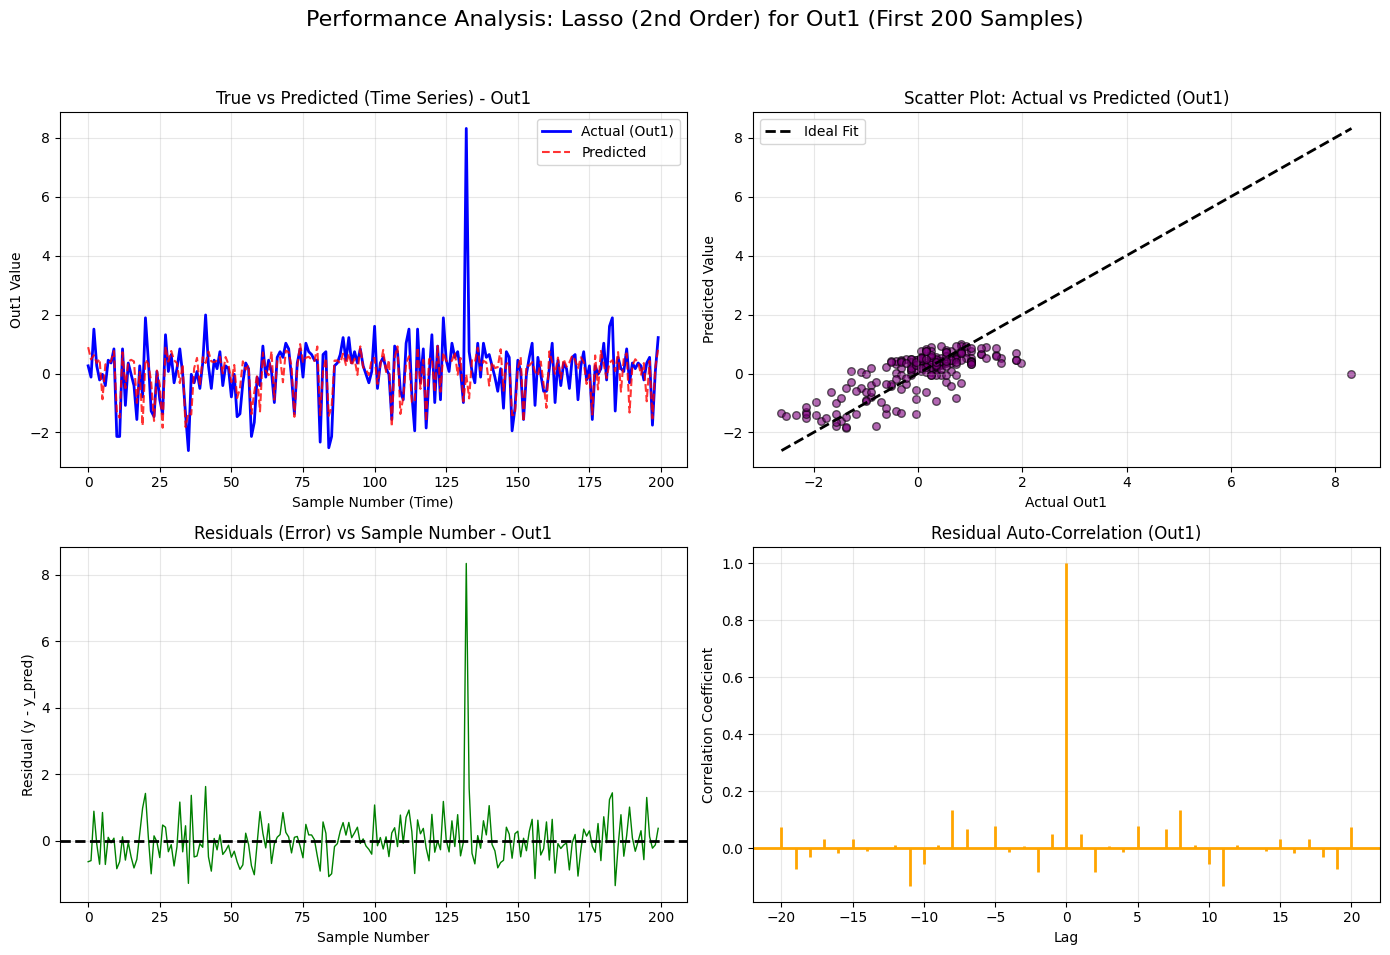

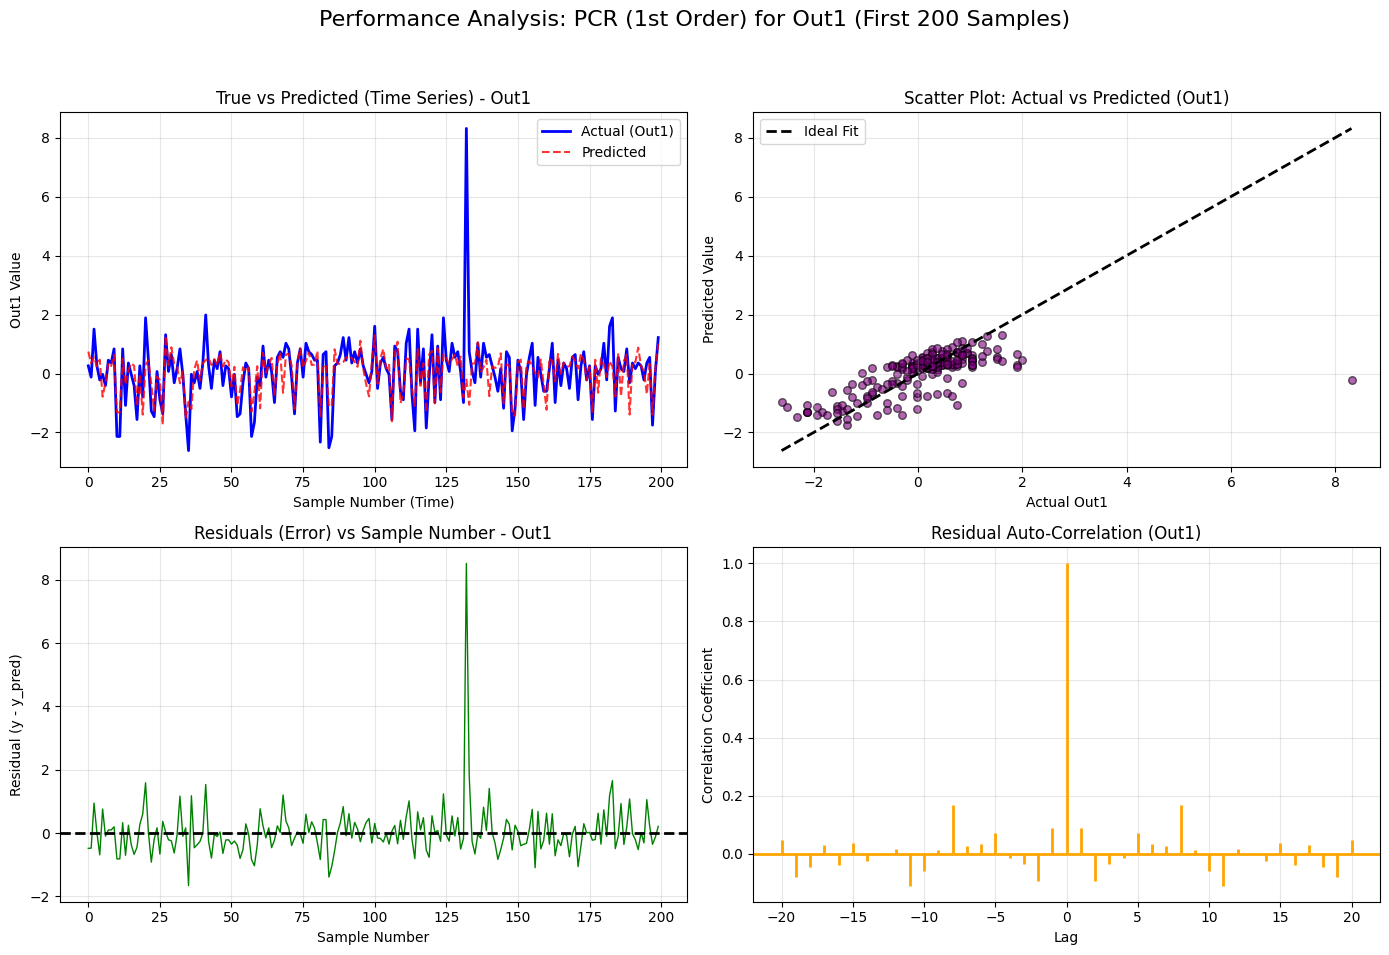

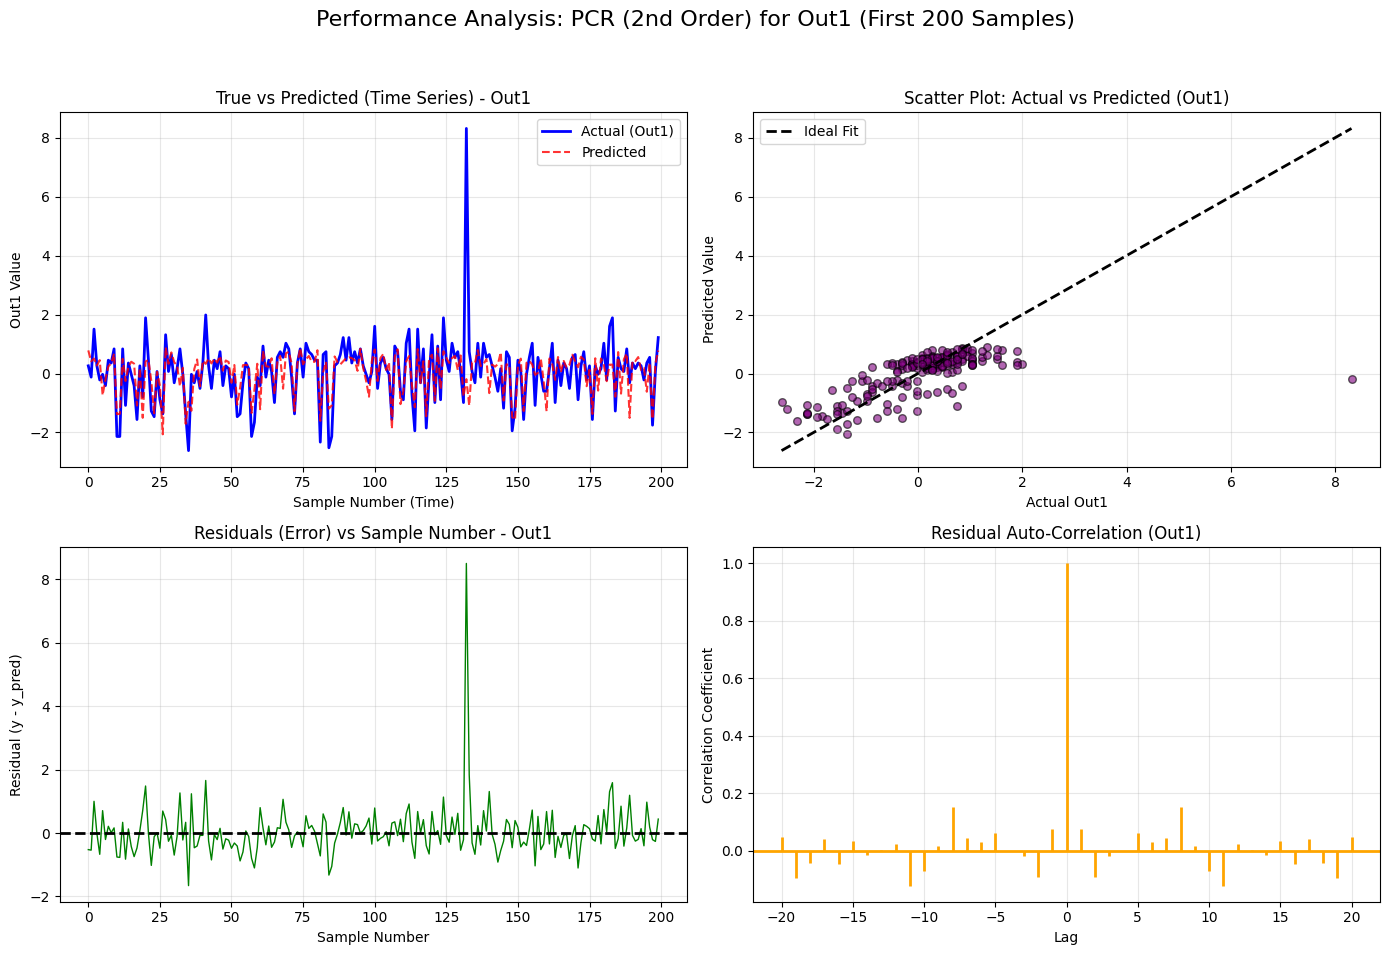

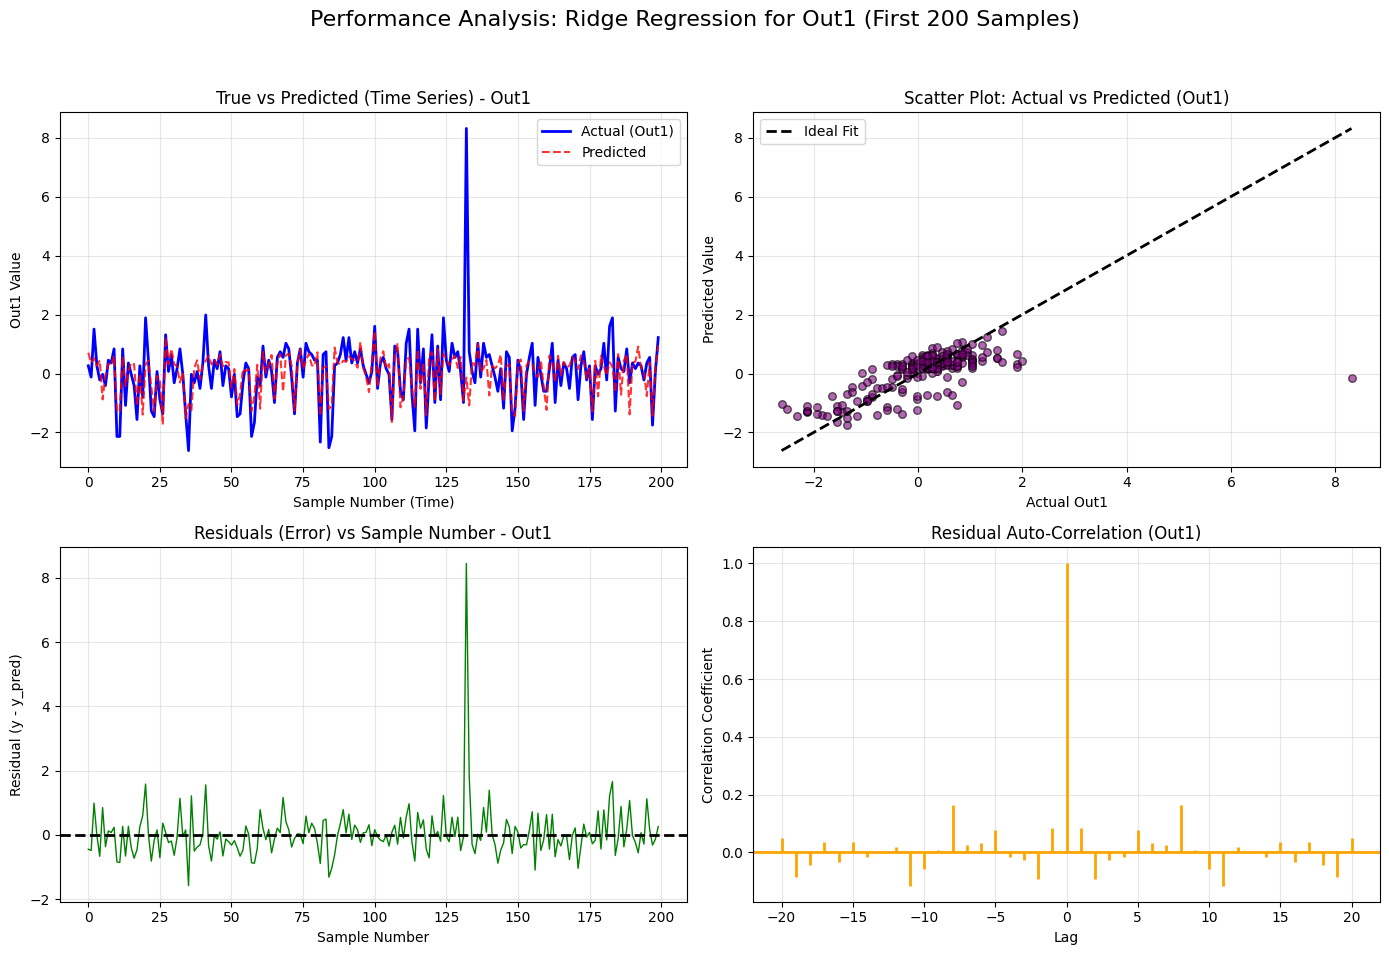

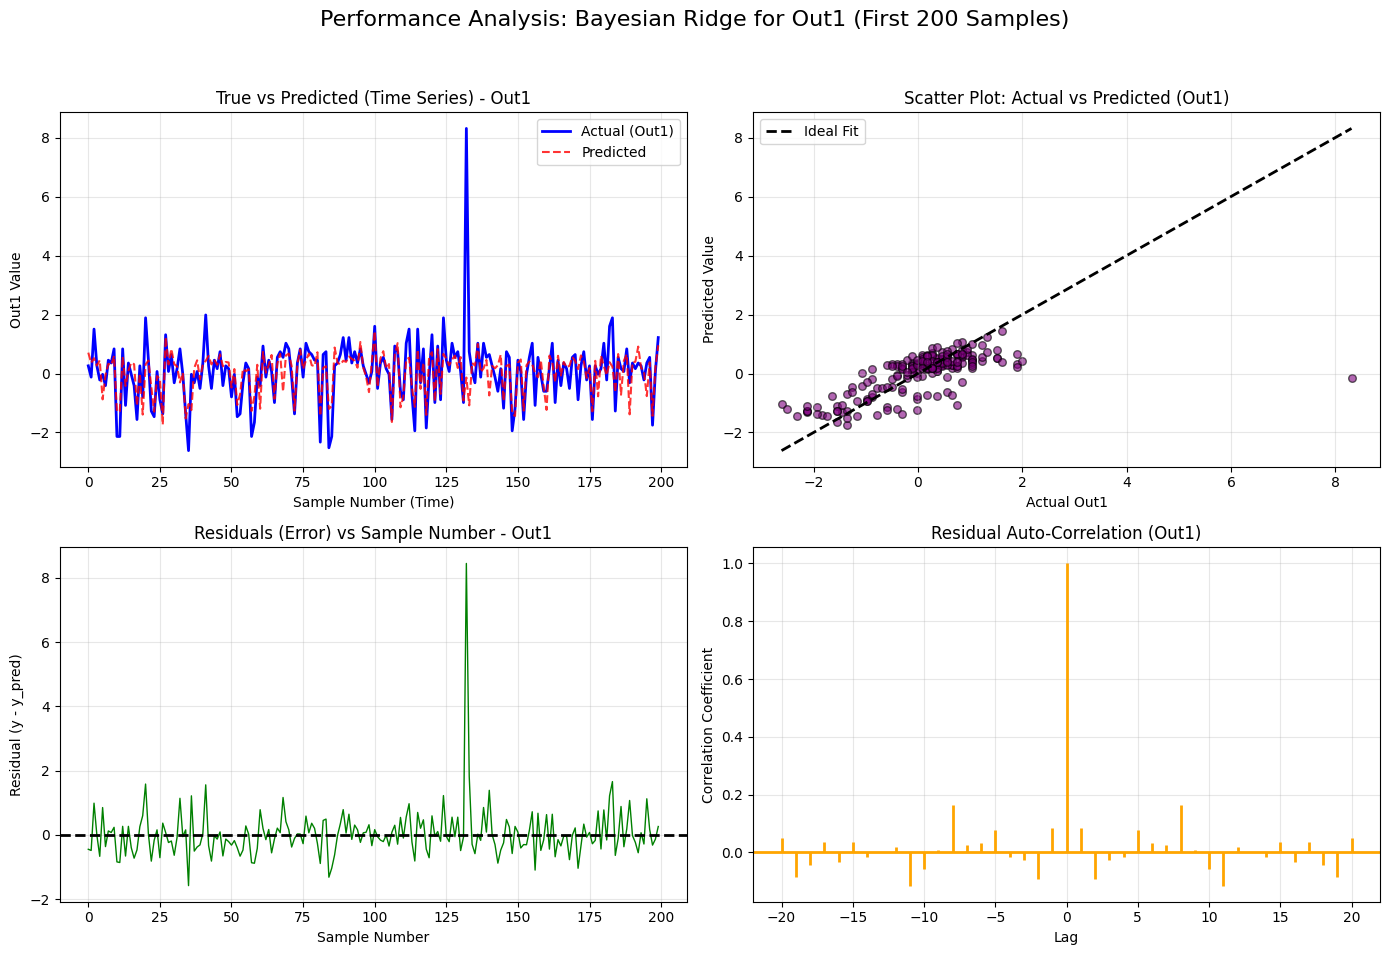

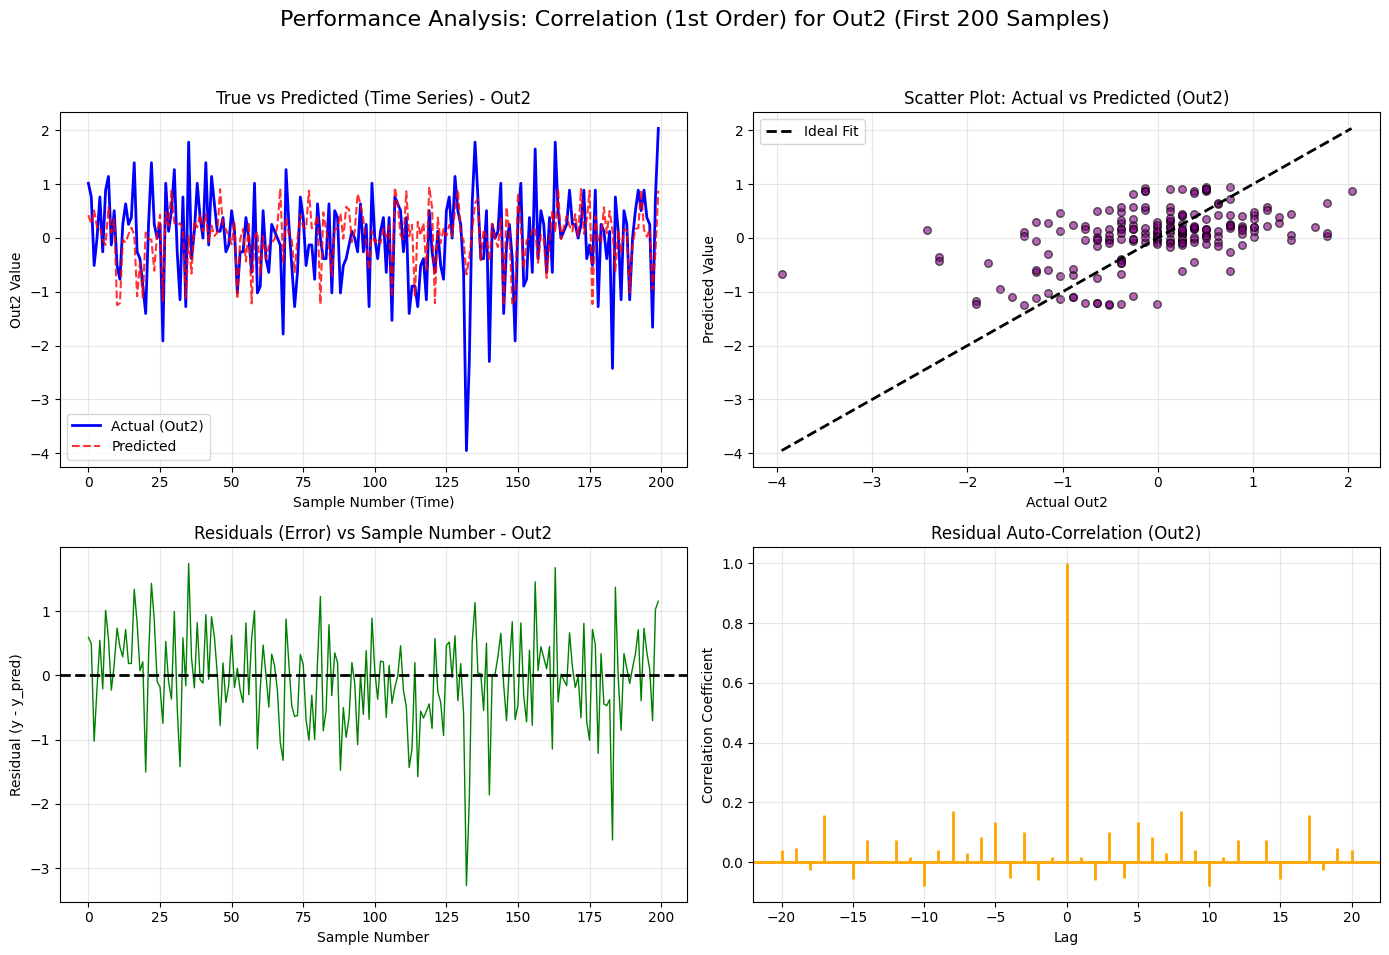

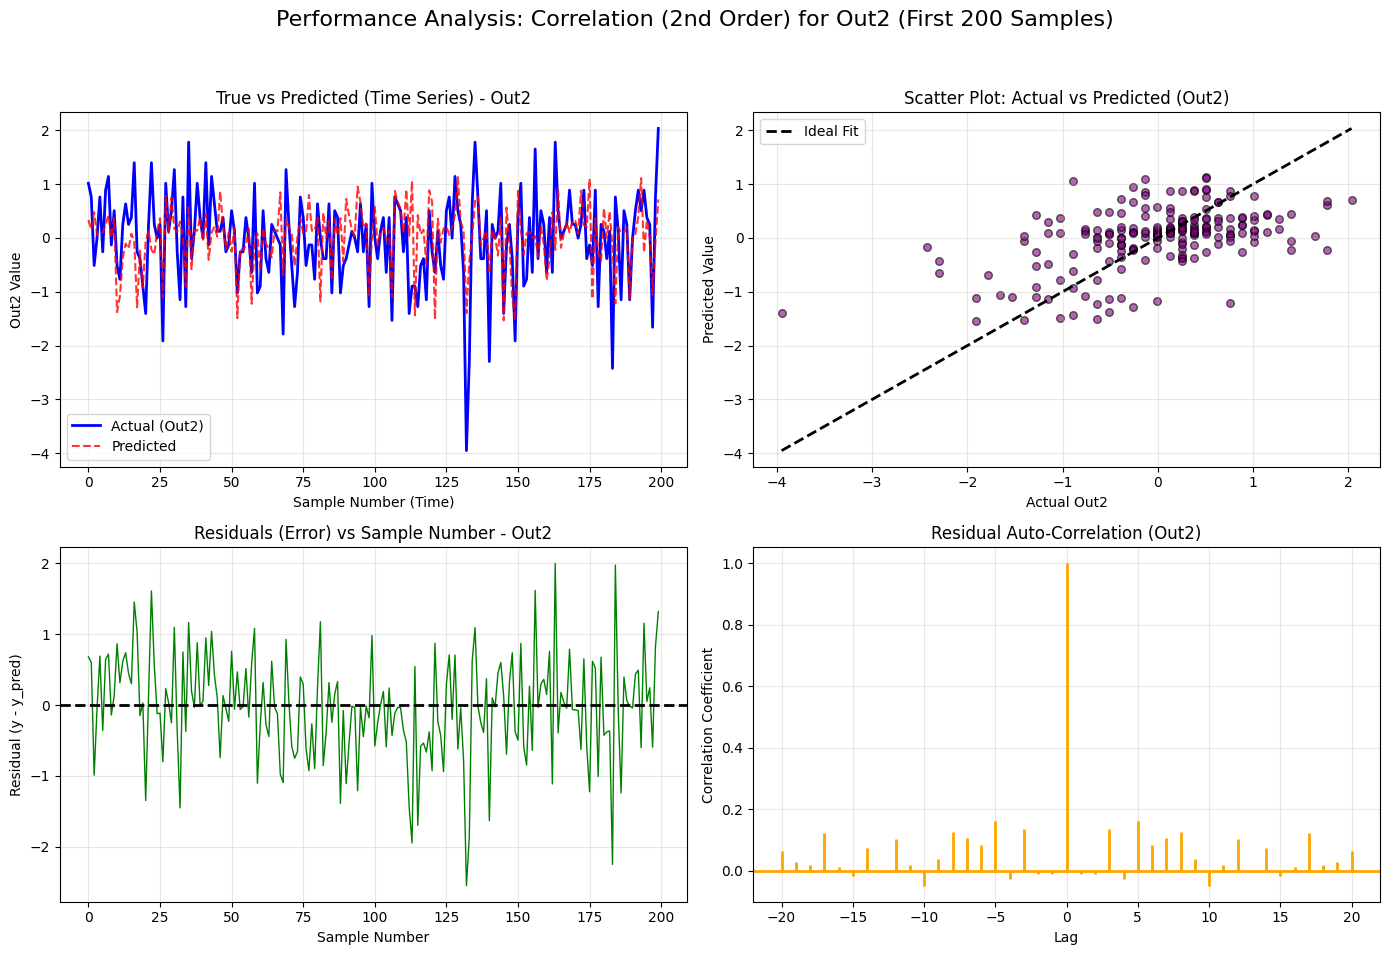

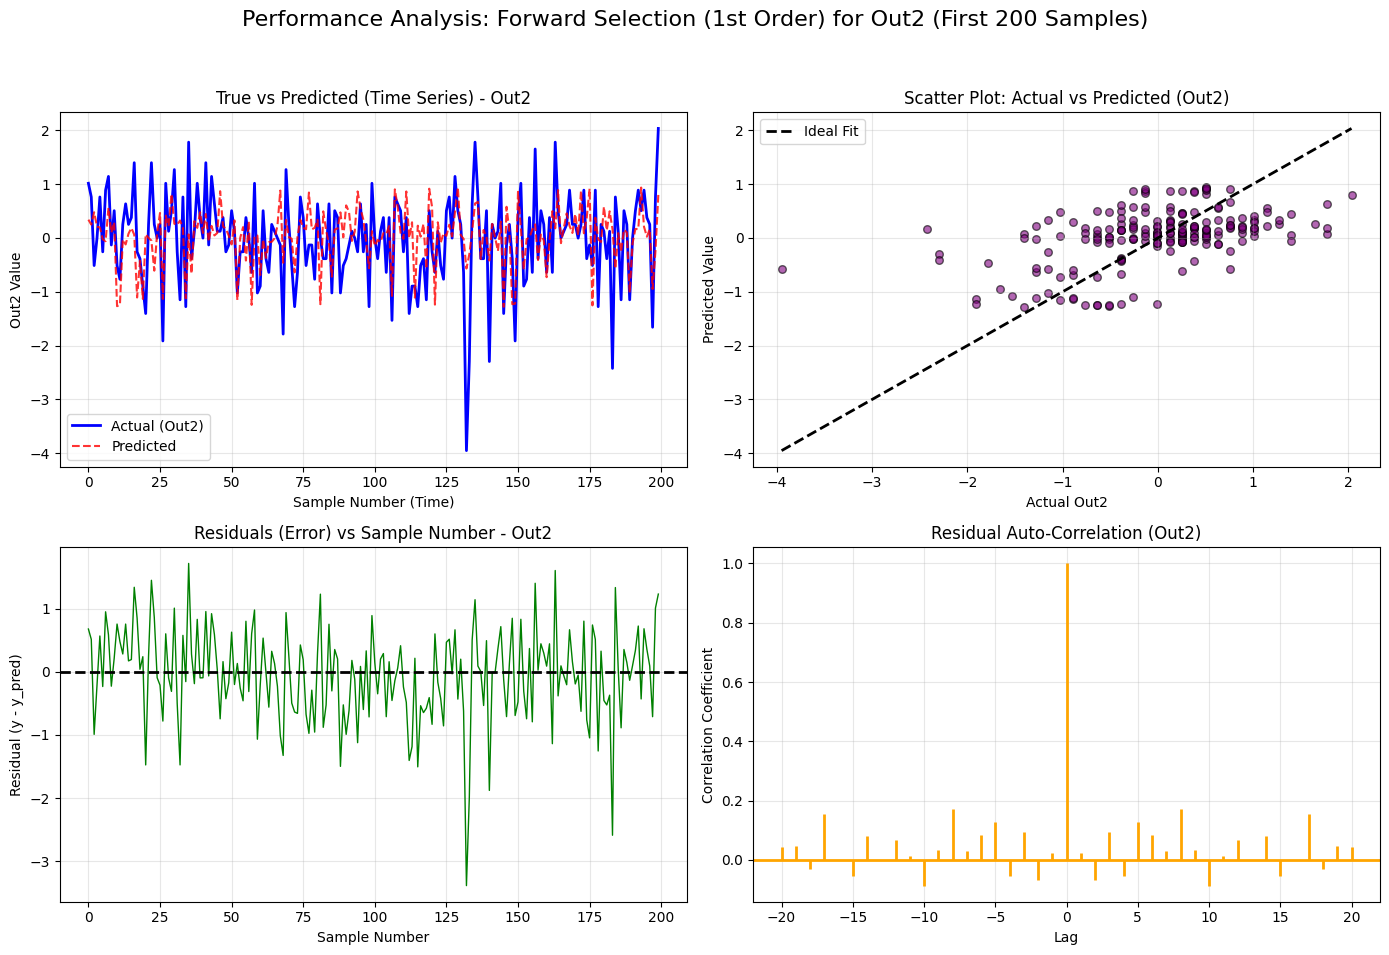

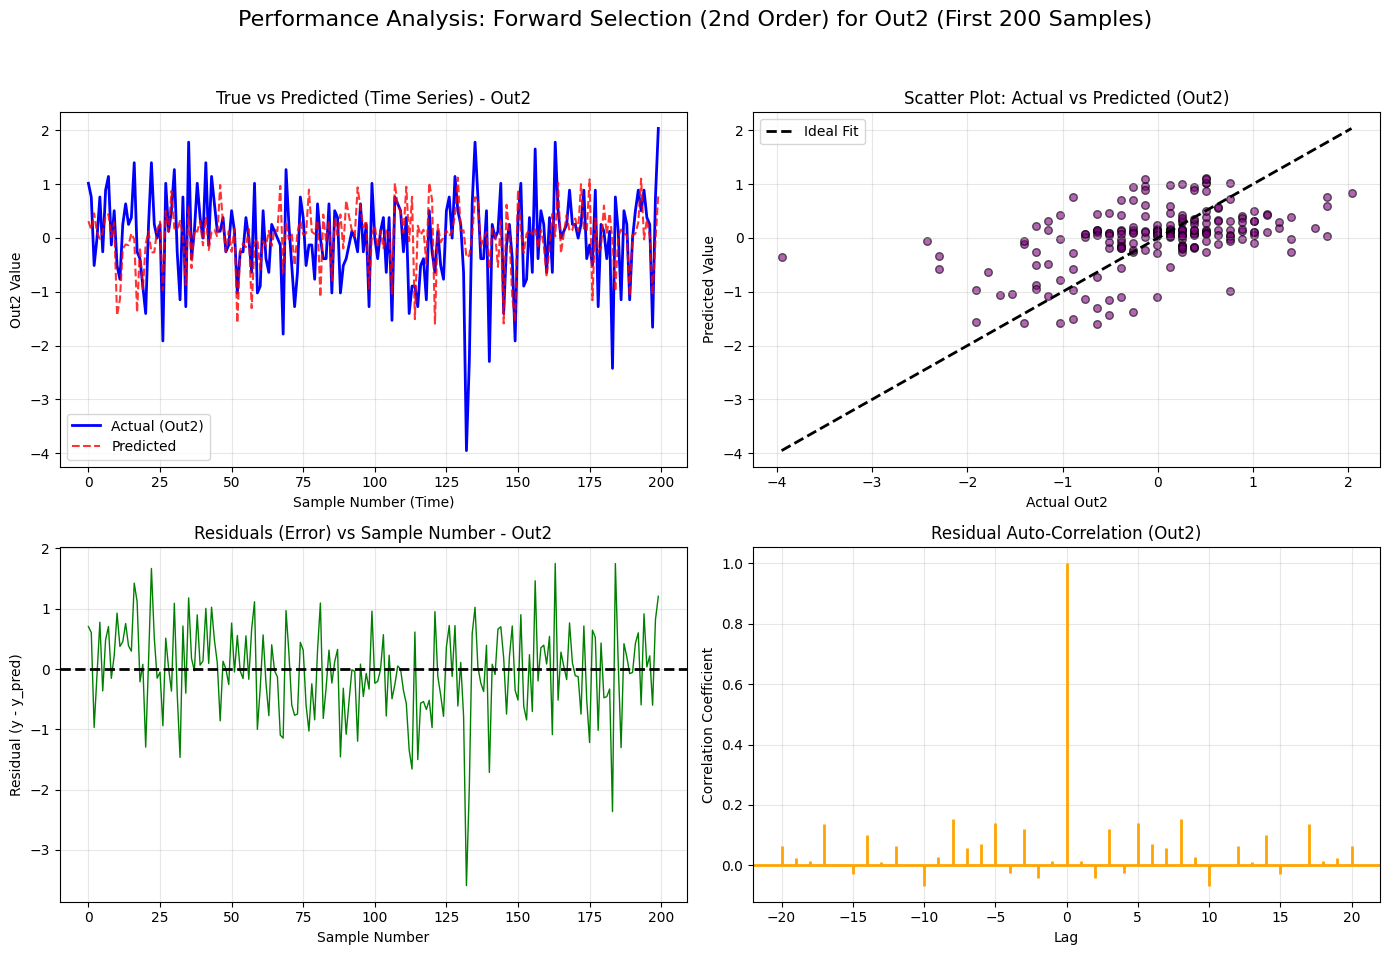

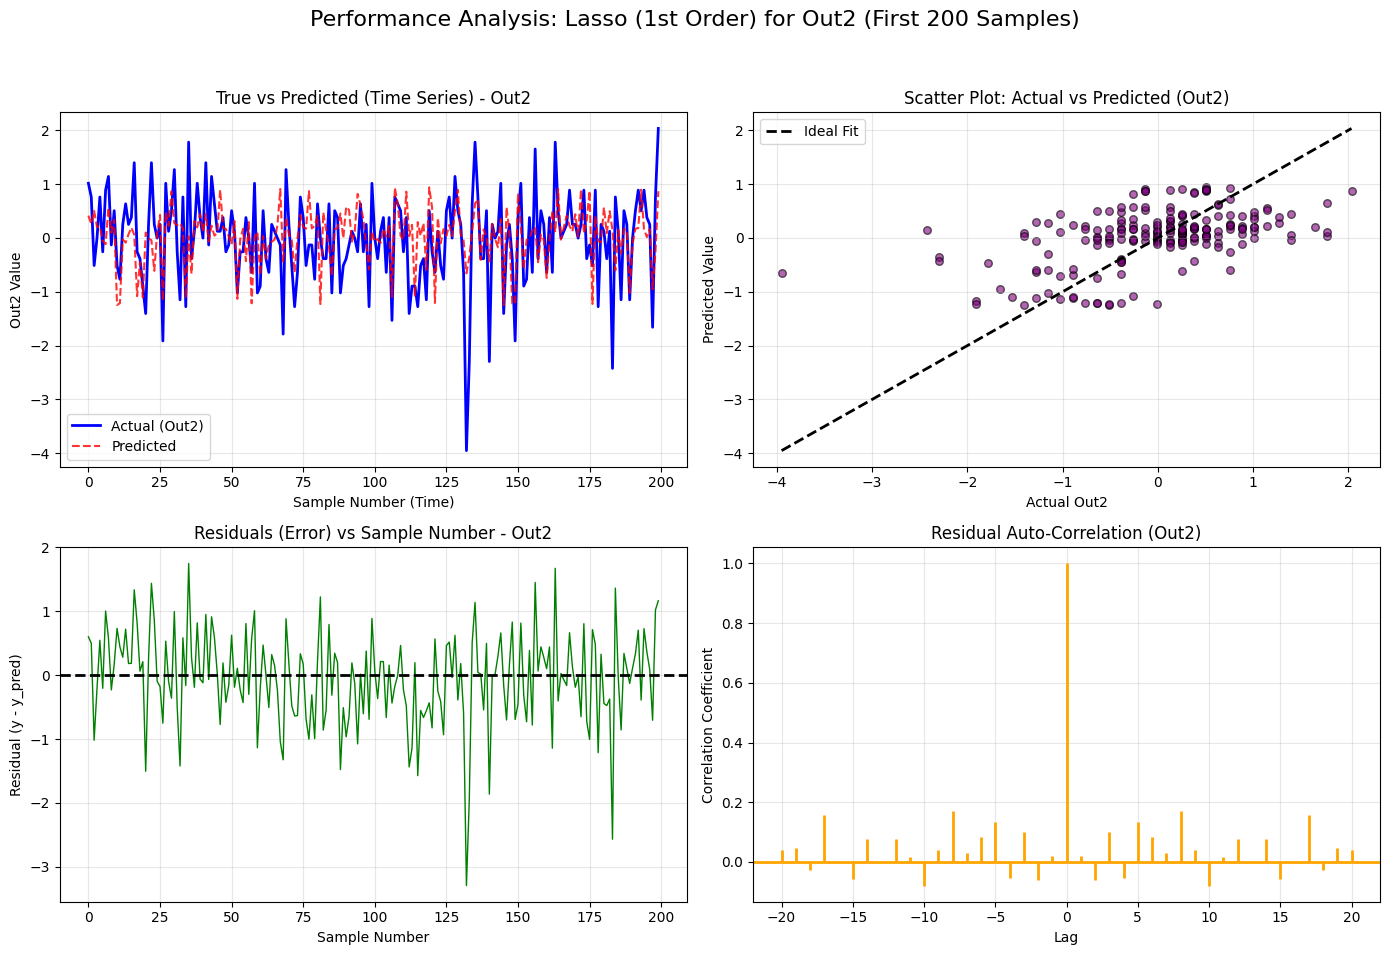

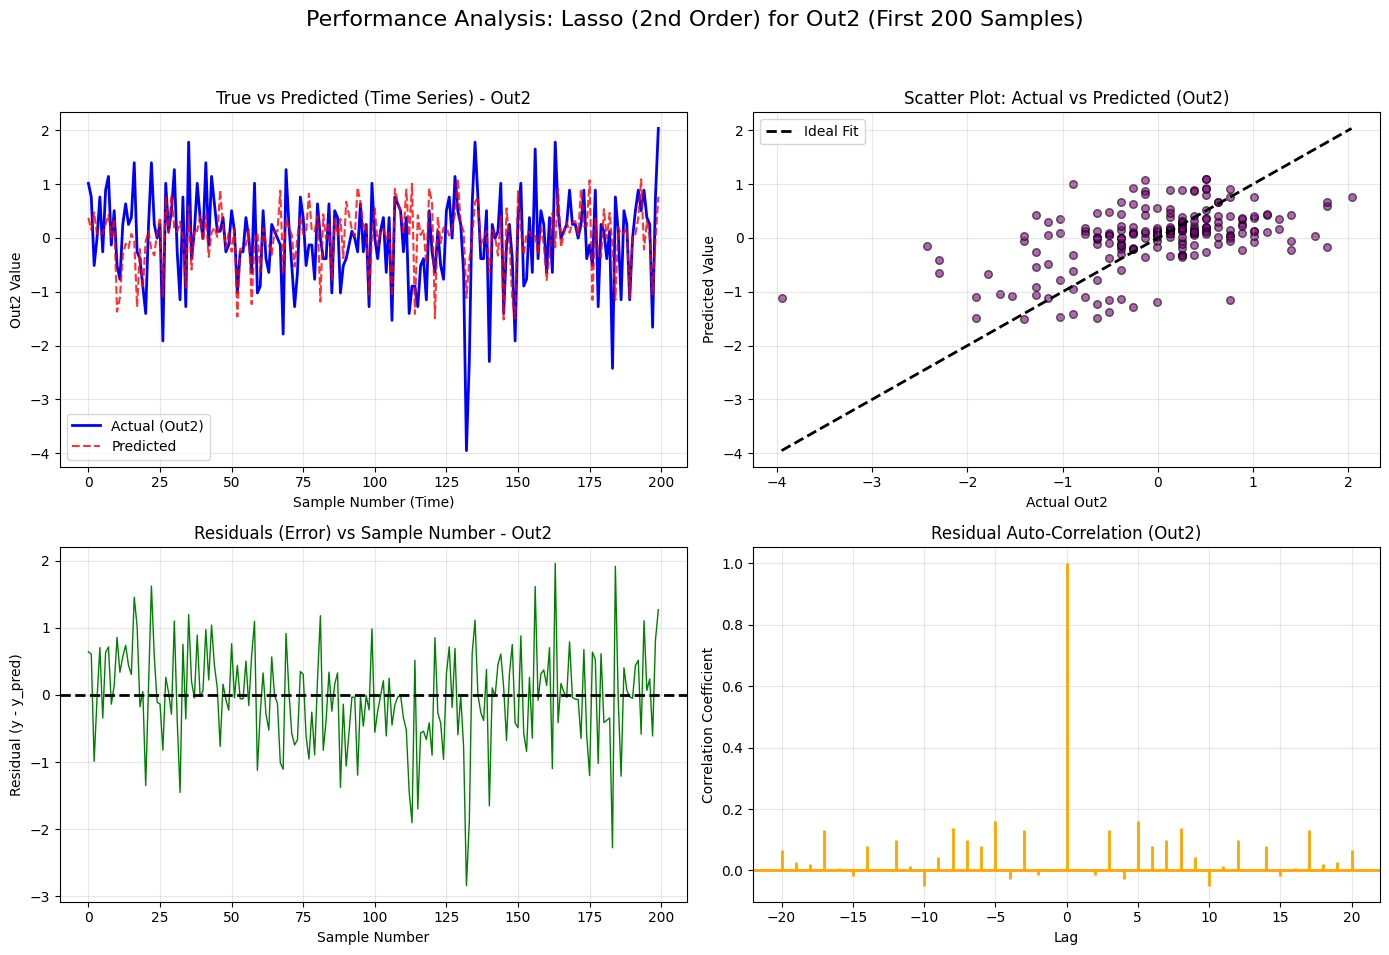

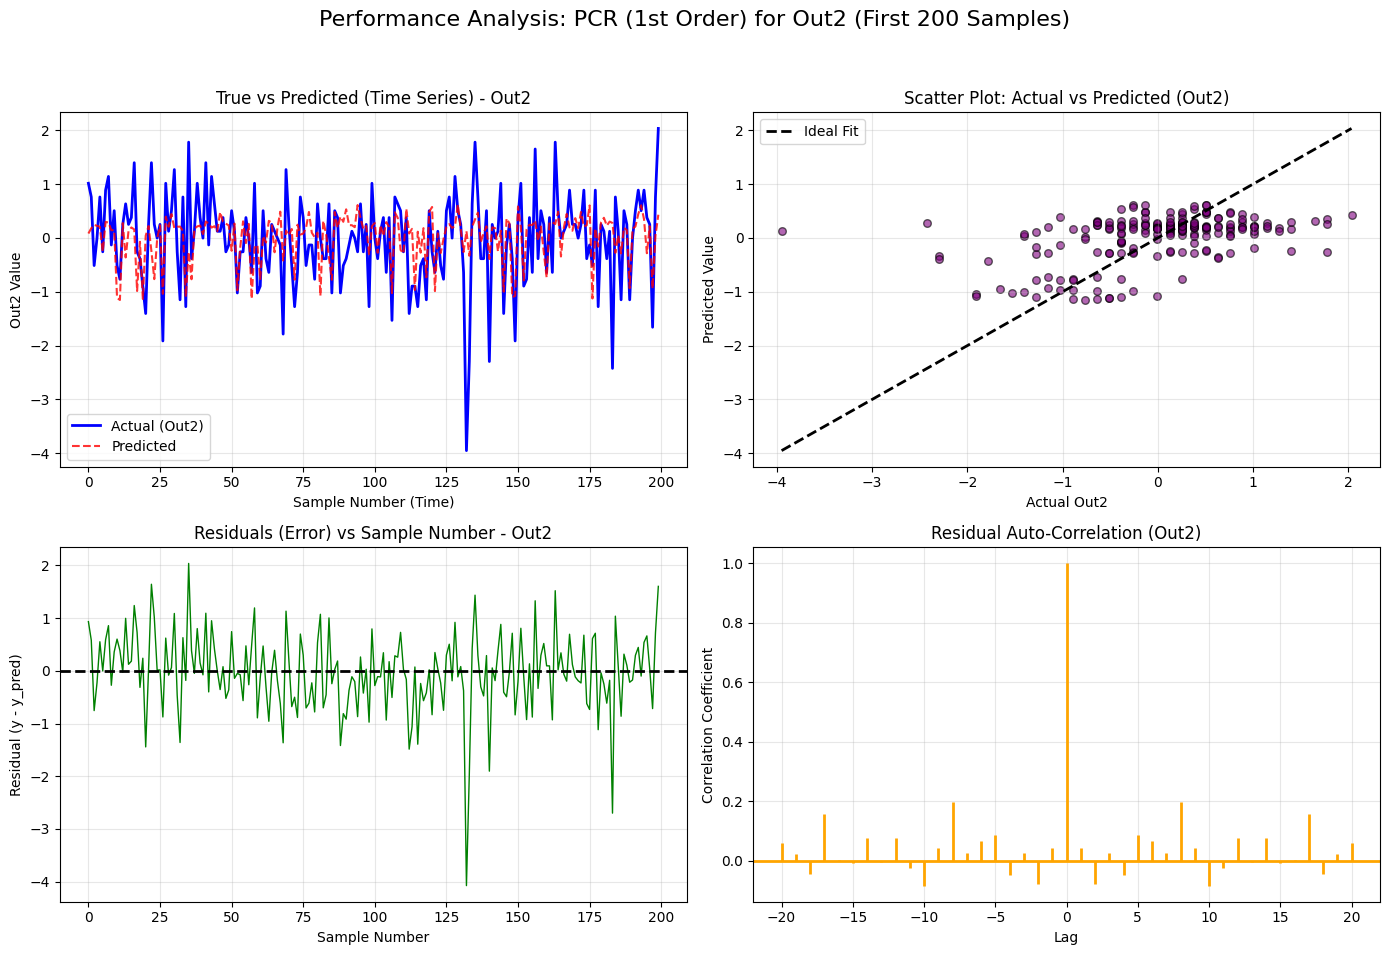

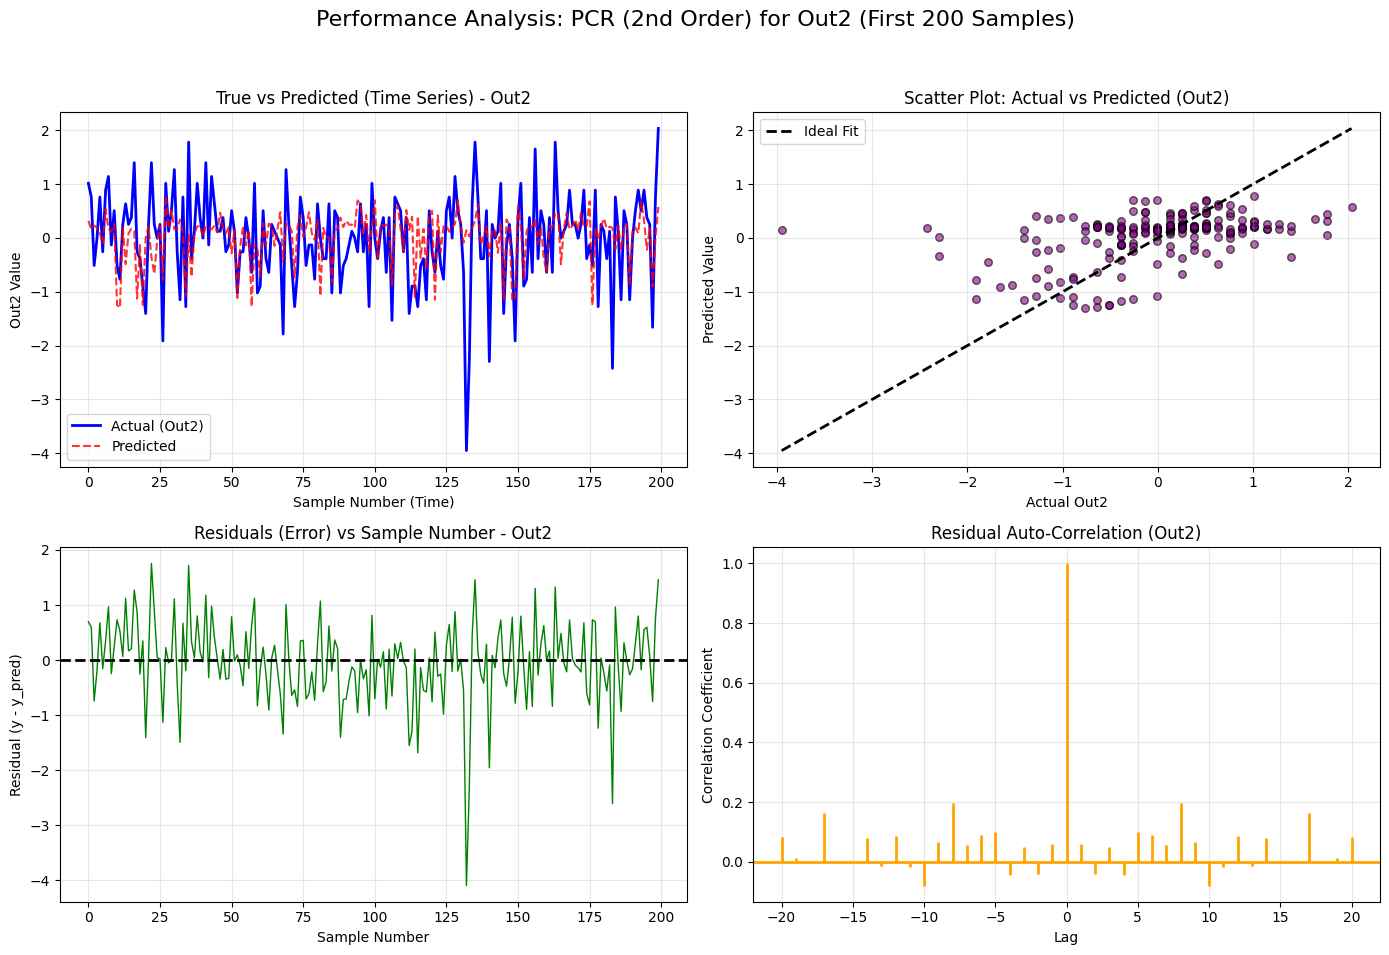

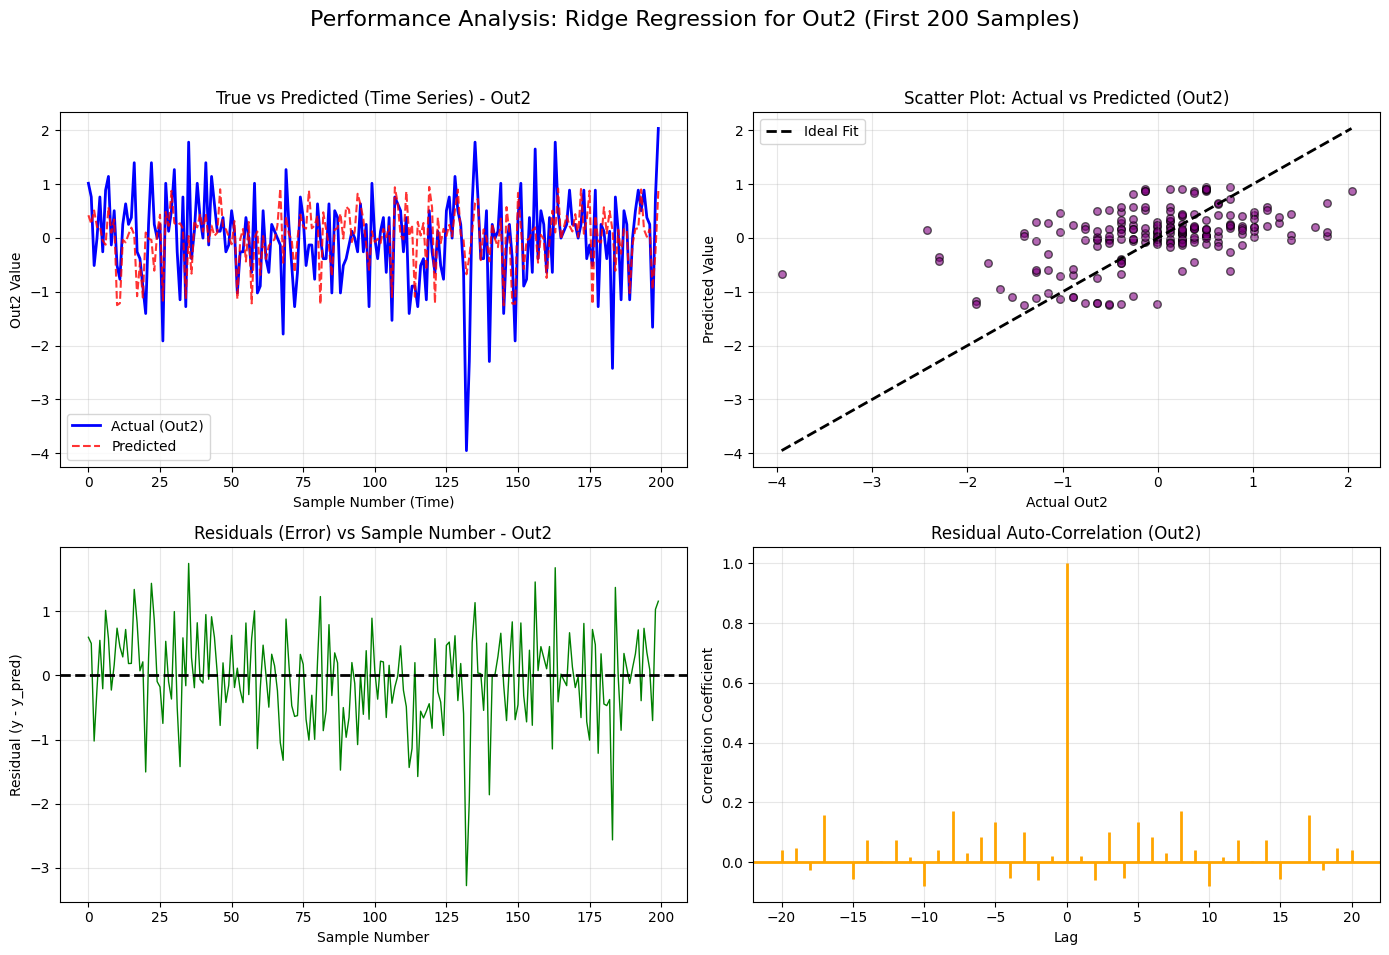

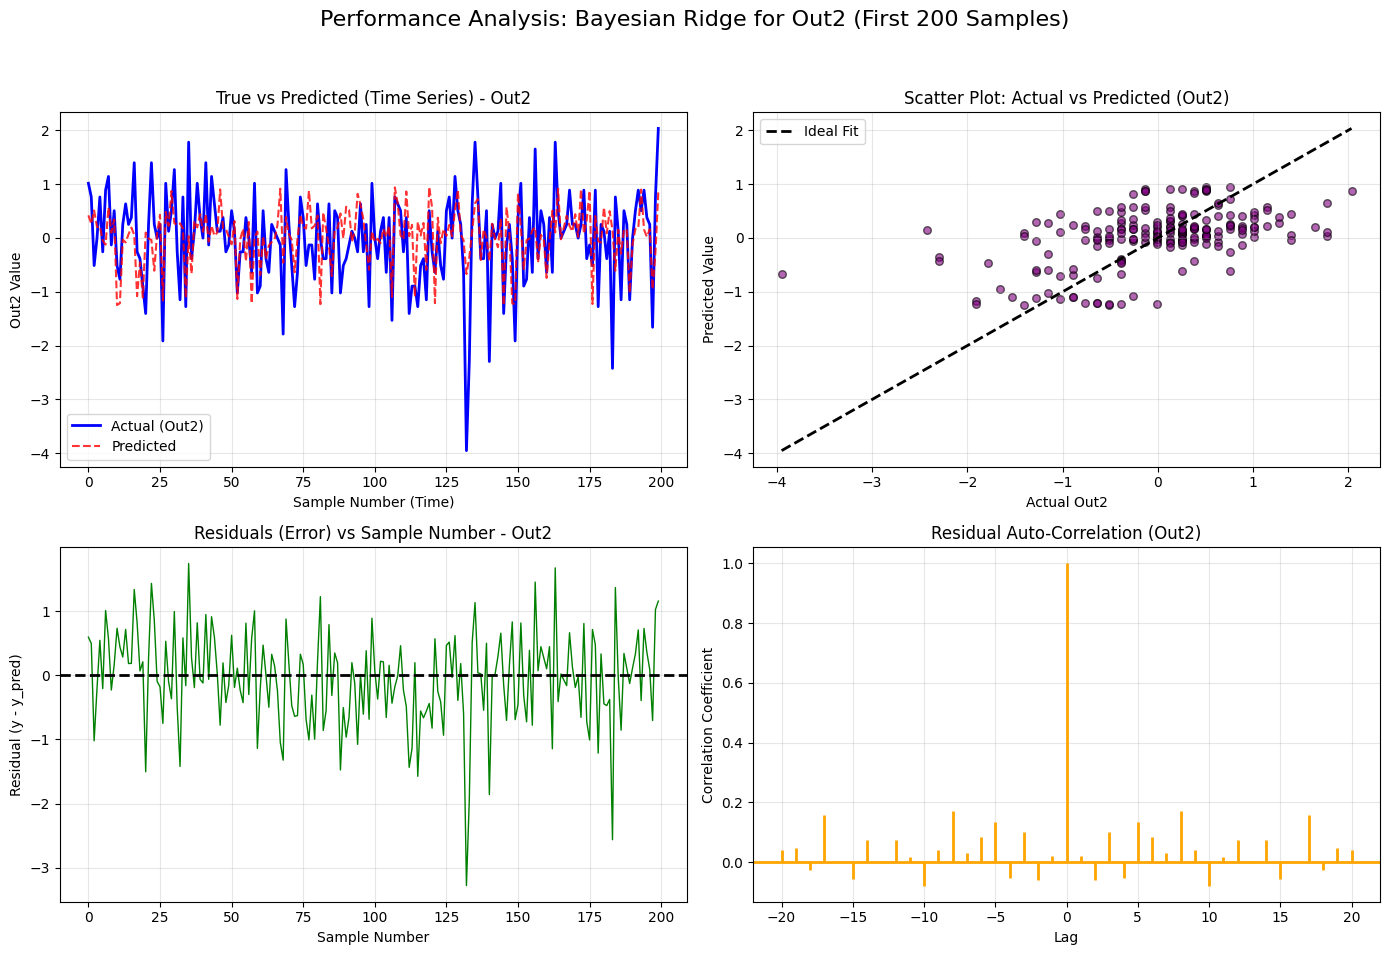

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, BayesianRidge
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score

#  1. EVALUATION & PLOTTING FUNCTION (UPDATED)
def evaluate(name, model, X_train, X_test, y_train, y_test, results_dict, target_name):

    # 1. Prediction
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # 2. Metrics Calculation (On FULL Test Set)
    # Basic Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Advanced Metrics (SSE, AIC, BIC)
    residuals = y_test - y_test_pred
    sse = np.sum(residuals**2)
    n = len(y_test)
    # k = number of features (columns) + 1 (intercept)
    k = X_test.shape[1] + 1

    # Standard AIC/BIC formulas for Least Squares
    if sse > 0:
        aic = n * np.log(sse/n) + 2 * k
        bic = n * np.log(sse/n) + k * np.log(n)
    else:
        aic, bic = -np.inf, -np.inf


    print(f"\n{'='*50}")
    print(f" MODEL: {name}  |  TARGET: {target_name}")
    print(f"{'='*50}")
    print(f" Train R2 : {train_r2:.4f}")
    print(f" Test R2  : {test_r2:.4f}")
    print(f" RMSE     : {rmse:.4f}")
    print(f" SSE      : {sse:.4f}")
    print(f" AIC      : {aic:.4f}")
    print(f" BIC      : {bic:.4f}")

    # Store for summary
    results_dict[name] = {'Test R2': test_r2, 'SSE': sse, 'AIC': aic, 'BIC': bic}

    # 3. Plotting (Subset of 200 samples only for clarity)

    limit = 200
    if len(y_test) > limit:
        # Use first 200 samples without sorting to preserve time order
        y_test_sub = y_test[:limit]
        y_pred_sub = y_test_pred[:limit]
        resid_sub = residuals[:limit]
    else:
        y_test_sub = y_test
        y_pred_sub = y_test_pred
        resid_sub = residuals

    # Reset index for plotting continuity
    y_test_sub = y_test_sub.reset_index(drop=True) if isinstance(y_test_sub, pd.Series) else y_test_sub

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    # UPDATED TITLE TO INCLUDE TARGET NAME
    fig.suptitle(f"Performance Analysis: {name} for {target_name} (First {limit} Samples)", fontsize=16)

    # Plot A: True vs Predicted (Time Series)
    axes[0, 0].plot(y_test_sub, label=f"Actual ({target_name})", color='blue', linewidth=2)
    axes[0, 0].plot(y_pred_sub, label="Predicted", color='red', linestyle='--', alpha=0.8)
    axes[0, 0].set_title(f"True vs Predicted (Time Series) - {target_name}")
    axes[0, 0].set_xlabel("Sample Number (Time)")
    axes[0, 0].set_ylabel(f"{target_name} Value")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot B: Scatter Plot
    axes[0, 1].scatter(y_test_sub, y_pred_sub, alpha=0.6, color='purple', edgecolor='k', s=30)
    # Draw Ideal 45-degree line
    min_val = min(y_test_sub.min(), y_pred_sub.min())
    max_val = max(y_test_sub.max(), y_pred_sub.max())
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Fit')
    axes[0, 1].set_title(f"Scatter Plot: Actual vs Predicted ({target_name})")
    axes[0, 1].set_xlabel(f"Actual {target_name}")
    axes[0, 1].set_ylabel("Predicted Value")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot C: Residuals vs Samples
    axes[1, 0].plot(resid_sub.values if hasattr(resid_sub, 'values') else resid_sub, color='green', linewidth=1)
    axes[1, 0].axhline(0, color='black', linestyle='--', lw=2)
    axes[1, 0].set_title(f"Residuals (Error) vs Sample Number - {target_name}")
    axes[1, 0].set_xlabel("Sample Number")
    axes[1, 0].set_ylabel("Residual (y - y_pred)")
    axes[1, 0].grid(True, alpha=0.3)

    # Plot D: Auto-correlation of Residuals
    # We subtract mean to center data for correlation check
    resid_centered = resid_sub - np.mean(resid_sub)
    if len(resid_centered) > 0:
        axes[1, 1].acorr(resid_centered.values.flatten() if hasattr(resid_centered, 'values') else resid_centered.flatten(),
                         maxlags=20, color='orange', lw=2, usevlines=True)
        axes[1, 1].set_title(f"Residual Auto-Correlation ({target_name})")
        axes[1, 1].set_xlabel("Lag")
        axes[1, 1].set_ylabel("Correlation Coefficient")
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # UPDATED FILENAME TO INCLUDE TARGET NAME
    filename = f"{target_name}{name.replace(' ','').replace('/','-')}_Analysis.png"
    plt.savefig(filename)
    # plt.show() # Uncomment to view in notebook
    print(f"Saved plot: {filename}")


#  2. MAIN EXECUTION LOOP
# Load Data
try:
    df_in = pd.read_csv('IN_Table.csv')
    df_out = pd.read_csv('OUT_Table.csv')
except FileNotFoundError:
    df_in = pd.read_csv('/content/IN_Table.csv')
    df_out = pd.read_csv('/content/OUT_Table.csv')

targets = ["Out1", "Out2"]
poly = PolynomialFeatures(2, include_bias=False)

for target in targets:
    print(f"\n{'='*60}")
    print(f" PROCESSING TARGET: {target}")
    print(f"{'='*60}")

    # Dictionary to track best model for this target
    model_performance = {}

    X = df_in.copy()
    y = df_out[target]

    # A. Split Data (70% Train, 30% Validation)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42
    )

    # B. Scaling
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # METHOD 1: CORRELATION SELECTION
    df_temp = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
    corr = df_temp.corr()[target].drop(target)
    selected_corr = corr.abs().nlargest(5).index.tolist()

    X_train_corr = X_train[selected_corr]
    X_test_corr = X_test[selected_corr]

    # 1.1 First Order
    model_corr = LinearRegression()
    model_corr.fit(X_train_corr, y_train)
    evaluate(f"Correlation (1st Order)", model_corr, X_train_corr, X_test_corr, y_train, y_test, model_performance, target)

    # 1.2 Second Order
    X_train_corr_poly = poly.fit_transform(X_train_corr)
    X_test_corr_poly = poly.transform(X_test_corr)
    model_corr_poly = LinearRegression()
    model_corr_poly.fit(X_train_corr_poly, y_train)
    evaluate(f"Correlation (2nd Order)", model_corr_poly, X_train_corr_poly, X_test_corr_poly, y_train, y_test, model_performance, target)

    # METHOD 2: FORWARD SELECTION
    lr = LinearRegression()
    max_feats = X_train_s.shape[1]
    n_select = min(5, max_feats - 1) if max_feats > 1 else 1

    sfs = SequentialFeatureSelector(lr, n_features_to_select=n_select, direction='forward')
    sfs.fit(X_train_s, y_train)
    sel_forward_idx = sfs.get_support(indices=True)
    sel_forward = X.columns[sel_forward_idx].tolist()

    X_train_fs = X_train[sel_forward]
    X_test_fs = X_test[sel_forward]

    # 2.1 First Order
    model_fs = LinearRegression()
    model_fs.fit(X_train_fs, y_train)
    evaluate(f"Forward Selection (1st Order)", model_fs, X_train_fs, X_test_fs, y_train, y_test, model_performance, target)

    # 2.2 Second Order
    X_train_fs_poly = poly.fit_transform(X_train_fs)
    X_test_fs_poly = poly.transform(X_test_fs)
    model_fs_poly = LinearRegression()
    model_fs_poly.fit(X_train_fs_poly, y_train)
    evaluate(f"Forward Selection (2nd Order)", model_fs_poly, X_train_fs_poly, X_test_fs_poly, y_train, y_test, model_performance, target)

    # METHOD 3: LASSO REGRESSION
    # 3.1 First Order
    lasso = LassoCV(cv=5, max_iter=10000, random_state=42)
    lasso.fit(X_train_s, y_train)
    evaluate(f"Lasso (1st Order)", lasso, X_train_s, X_test_s, y_train, y_test, model_performance, target)

    # 3.2 Second Order
    X_train_poly_all = poly.fit_transform(X_train_s)
    X_test_poly_all = poly.transform(X_test_s)
    lasso_poly = LassoCV(cv=5, max_iter=10000, random_state=42)
    lasso_poly.fit(X_train_poly_all, y_train)
    evaluate(f"Lasso (2nd Order)", lasso_poly, X_train_poly_all, X_test_poly_all, y_train, y_test, model_performance, target)

    # METHOD 4: PCA BASED FEATURE SELECTION (PCR)
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_s)
    X_test_pca = pca.transform(X_test_s)

    # 4.1 PCR First Order
    pcr = LinearRegression()
    pcr.fit(X_train_pca, y_train)
    evaluate(f"PCR (1st Order)", pcr, X_train_pca, X_test_pca, y_train, y_test, model_performance, target)

    # 4.2 PCR Second Order
    X_train_pca_poly = poly.fit_transform(X_train_pca)
    X_test_pca_poly = poly.transform(X_test_pca)
    pcr2 = LinearRegression()
    pcr2.fit(X_train_pca_poly, y_train)
    evaluate(f"PCR (2nd Order)", pcr2, X_train_pca_poly, X_test_pca_poly, y_train, y_test, model_performance, target)

    # METHOD 5: RIDGE & BAYESIAN REGRESSION
    # 5.1 Ridge
    ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])
    ridge.fit(X_train_s, y_train)
    evaluate(f"Ridge Regression", ridge, X_train_s, X_test_s, y_train, y_test, model_performance, target)

    # 5.2 Bayesian Ridge
    bay = BayesianRidge()
    bay.fit(X_train_s, y_train)
    evaluate(f"Bayesian Ridge", bay, X_train_s, X_test_s, y_train, y_test, model_performance, target)

    # SUMMARY: BEST MODEL SELECTION
    sorted_models = sorted(model_performance.items(), key=lambda x: x[1]['Test R2'], reverse=True)

    print(f"\n[SUMMARY] Model Ranking for {target} (Sorted by R2):")
    print(f"{'Model Name':<30} | {'R2':<8} | {'SSE':<10} | {'AIC':<10} | {'BIC':<10}")
    print("-" * 90)
    for name, metrics in sorted_models:
        print(f"{name:<30} | {metrics['Test R2']:.4f}   | {metrics['SSE']:.2f}     | {metrics['AIC']:.1f}      | {metrics['BIC']:.1f}")
    print("-" * 90)

In [4]:
# ============================================================
# CHE512 – COURSE PROJECT PART 2
# Nonlinear Soft Sensor Models using Neural Networks
# (for both Out1 and Out2)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# ----------------- GLOBAL SETTINGS -----------------
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.size"] = 10

np.random.seed(42)
tf.random.set_seed(42)

N_PLOT = 200  # max samples for plots


# ============================================================
# 0. EVALUATION FUNCTIONS
# ============================================================
def evaluate(name, model, X_train, X_test, y_train, y_test, results_dict, target_name):
    """
    Compute Train R2, Test R2, RMSE, SSE, AIC, BIC
    and generate:
    - True vs Predicted (time)
    - Scatter
    - Residuals vs sample
    - Residual ACF
    using only first N_PLOT test samples.
    """
    # Predictions
    y_test_pred = model.predict(X_test).reshape(-1)
    y_train_pred = model.predict(X_train).reshape(-1)

    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    residuals = y_test - y_test_pred
    sse = float(np.sum(residuals ** 2))
    n = len(y_test)

    # Approximate parameter count for AIC/BIC
    if X_test.ndim == 2:
        k = X_test.shape[1] + 1
    elif X_test.ndim == 3:
        k = X_test.shape[1] * X_test.shape[2] + 1
    else:
        k = 1

    if sse <= 0:
        aic, bic = np.inf, np.inf
    else:
        aic = n * np.log(sse / n) + 2 * k
        bic = n * np.log(sse / n) + k * np.log(n)

    print(f"\n{'='*60}")
    print(f" MODEL: {name}  |  TARGET: {target_name}")
    print(f"{'='*60}")
    print(f" Train R2 : {train_r2:.4f}")
    print(f" Test R2  : {test_r2:.4f}")
    print(f" RMSE     : {rmse:.4f}")
    print(f" SSE      : {sse:.4f}")
    print(f" AIC      : {aic:.4f}")
    print(f" BIC      : {bic:.4f}")

    results_dict[name] = {"Test R2": test_r2, "SSE": sse, "AIC": aic, "BIC": bic}

    # ---- Plotting (first N_PLOT samples) ----
    if isinstance(y_test, pd.Series):
        y_test_series = y_test.reset_index(drop=True)
    else:
        y_test_series = pd.Series(y_test)

    n_plot = min(N_PLOT, len(y_test_series))
    y_true_plot = y_test_series.iloc[:n_plot]
    y_pred_plot = y_test_pred[:n_plot]
    resid_plot = y_true_plot - y_pred_plot

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"{name} – {target_name} (first {n_plot} test samples)", fontsize=14)

    # A: Time comparison
    axes[0, 0].plot(y_true_plot, label="Actual")
    axes[0, 0].plot(y_pred_plot, "--", label="Predicted")
    axes[0, 0].set_title("True vs Predicted (Time Series)")
    axes[0, 0].set_xlabel("Sample index")
    axes[0, 0].set_ylabel(target_name)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # B: Scatter
    axes[0, 1].scatter(y_true_plot, y_pred_plot, alpha=0.6)
    mn = min(y_true_plot.min(), y_pred_plot.min())
    mx = max(y_true_plot.max(), y_pred_plot.max())
    axes[0, 1].plot([mn, mx], [mn, mx], "k--")
    axes[0, 1].set_title("Scatter: Actual vs Predicted")
    axes[0, 1].set_xlabel("Actual")
    axes[0, 1].set_ylabel("Predicted")
    axes[0, 1].grid(True, alpha=0.3)

    # C: Residuals
    axes[1, 0].plot(resid_plot.values)
    axes[1, 0].axhline(0, color="k", linestyle="--")
    axes[1, 0].set_title("Residuals vs Sample")
    axes[1, 0].set_xlabel("Sample index")
    axes[1, 0].set_ylabel("Residual")
    axes[1, 0].grid(True, alpha=0.3)

    # D: Residual ACF
    resid_centered = resid_plot - resid_plot.mean()
    axes[1, 1].acorr(resid_centered.values, maxlags=20, usevlines=True)
    axes[1, 1].set_title("Residual Auto-Correlation")
    axes[1, 1].set_xlabel("Lag")
    axes[1, 1].set_ylabel("Correlation")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    filename = f"{target_name}_{name.replace(' ', '').replace('/', '-')}_Part2.png"
    plt.savefig(filename)
    plt.close()
    print(f"Saved plot: {filename}")


def evaluate_jit(name, y_test, y_pred, results_dict, target_name):
    """
    Evaluation & plots for JIT model, where predictions are pre-computed.
    """
    y_test_series = pd.Series(y_test)
    n_plot = min(N_PLOT, len(y_test_series))
    y_true_plot = y_test_series.iloc[:n_plot].reset_index(drop=True)
    y_pred_plot = np.array(y_pred)[:n_plot]

    test_r2 = r2_score(y_true_plot, y_pred_plot)
    rmse = np.sqrt(mean_squared_error(y_true_plot, y_pred_plot))
    residuals = y_true_plot - y_pred_plot
    sse = float(np.sum(residuals ** 2))
    n = len(y_true_plot)
    k = 1  # dummy for AIC/BIC
    if sse <= 0:
        aic, bic = np.inf, np.inf
    else:
        aic = n * np.log(sse / n) + 2 * k
        bic = n * np.log(sse / n) + k * np.log(n)

    print(f"\n{'='*60}")
    print(f" MODEL: {name}  |  TARGET: {target_name}")
    print(f"{'='*60}")
    print(f" Test R2  : {test_r2:.4f}")
    print(f" RMSE     : {rmse:.4f}")
    print(f" SSE      : {sse:.4f}")
    print(f" AIC      : {aic:.4f}")
    print(f" BIC      : {bic:.4f}")

    results_dict[name] = {"Test R2": test_r2, "SSE": sse, "AIC": aic, "BIC": bic}

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"{name} – {target_name} (first {n_plot} test samples)", fontsize=14)

    # A: Time comparison
    axes[0, 0].plot(y_true_plot, label="Actual")
    axes[0, 0].plot(y_pred_plot, "--", label="Predicted")
    axes[0, 0].set_title("True vs Predicted (Time Series)")
    axes[0, 0].set_xlabel("Sample index")
    axes[0, 0].set_ylabel(target_name)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # B: Scatter
    axes[0, 1].scatter(y_true_plot, y_pred_plot, alpha=0.6)
    mn = min(y_true_plot.min(), y_pred_plot.min())
    mx = max(y_true_plot.max(), y_pred_plot.max())
    axes[0, 1].plot([mn, mx], [mn, mx], "k--")
    axes[0, 1].set_title("Scatter: Actual vs Predicted")
    axes[0, 1].set_xlabel("Actual")
    axes[0, 1].set_ylabel("Predicted")
    axes[0, 1].grid(True, alpha=0.3)

    # C: Residuals
    axes[1, 0].plot(residuals.values)
    axes[1, 0].axhline(0, color="k", linestyle="--")
    axes[1, 0].set_title("Residuals vs Sample")
    axes[1, 0].set_xlabel("Sample index")
    axes[1, 0].set_ylabel("Residual")
    axes[1, 0].grid(True, alpha=0.3)

    # D: Residual ACF
    resid_centered = residuals - residuals.mean()
    axes[1, 1].acorr(resid_centered.values, maxlags=20, usevlines=True)
    axes[1, 1].set_title("Residual Auto-Correlation")
    axes[1, 1].set_xlabel("Lag")
    axes[1, 1].set_ylabel("Correlation")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    filename = f"{target_name}_{name.replace(' ', '').replace('/', '-')}_JIT_Part2.png"
    plt.savefig(filename)
    plt.close()
    print(f"Saved plot: {filename}")


# ============================================================
# 1. LOAD DATA
# ============================================================
df_in = pd.read_csv("IN_Table.csv")
df_out = pd.read_csv("OUT_Table.csv")

INPUT_COLS = list(df_in.columns)
TARGETS = ["Out1", "Out2"]  # adjust if needed

print("Inputs :", INPUT_COLS)
print("Targets:", TARGETS)


# ============================================================
# 2. HELPER FUNCTIONS
# ============================================================
def build_ffnn(input_dim, hidden_layers, lr, l2_reg):
    model = Sequential()
    # first hidden layer
    model.add(
        Dense(
            hidden_layers[0],
            activation="relu",
            input_shape=(input_dim,),
            kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None,
        )
    )
    # remaining hidden layers
    for units in hidden_layers[1:]:
        model.add(
            Dense(
                units,
                activation="relu",
                kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None,
            )
        )
    # output layer
    model.add(Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="mse")
    return model


def create_lstm_sequences(X_array, y_array, n_steps):
    """
    X_array: 2D (N, n_features), y_array: 1D (N,)
    returns X_seq: (N-n_steps, n_steps, n_features), y_seq: (N-n_steps,)
    """
    X_array = np.asarray(X_array)
    y_array = np.asarray(y_array)
    Xs, ys = [], []
    for i in range(n_steps, len(X_array)):
        Xs.append(X_array[i-n_steps:i, :])
        ys.append(y_array[i])
    return np.array(Xs), np.array(ys)


# ============================================================
# 3. MAIN LOOP OVER TARGETS
# ============================================================
for target in TARGETS:
    print("\n" + "=" * 70)
    print(f"PROCESSING TARGET (PART 2): {target}")
    print("=" * 70)

    X = df_in.copy()
    y = df_out[target].copy()

    # 70/30 split for static NNs (shuffled)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, shuffle=True, random_state=42
    )

    # scale full inputs
    scaler_all = StandardScaler()
    X_train_s = scaler_all.fit_transform(X_train)
    X_test_s = scaler_all.transform(X_test)

    # --------------------------------------------------------
    # 3.1 FEATURE SELECTION (CORRELATION) – use results from Part 1 idea
    # --------------------------------------------------------
    df_temp = pd.concat([X_train.reset_index(drop=True),
                         y_train.reset_index(drop=True)], axis=1)
    corr = df_temp.corr()[target].drop(target)
    selected_corr = corr.abs().nlargest(5).index.tolist()
    print("Correlation-selected inputs:", selected_corr)

    X_train_corr = X_train[selected_corr]
    X_test_corr = X_test[selected_corr]

    scaler_sel = StandardScaler()
    X_train_sel_s = scaler_sel.fit_transform(X_train_corr)
    X_test_sel_s = scaler_sel.transform(X_test_corr)

    # PCA (if you want to mention, though we don't use it directly in NNs)
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_s)
    X_test_pca = pca.transform(X_test_s)
    print("PCA components (>=95% variance):", X_train_pca.shape[1])

    # dict to store metrics for this target
    results_p2 = {}

    # ========================================================
    # 4. FEEDFORWARD NN (CONVENTIONAL NN) + HYPERPARAM TUNING
    # ========================================================
    print("\n--- Feedforward NN Hyperparameter Tuning ---")

    input_dim_nn = X_train_sel_s.shape[1]
    learning_rates = [1e-4, 1e-3, 1e-2]
    l2_regs = [0.0, 1e-4, 1e-3]
    architectures = [
        [32],         # shallow
        [32, 32],     # deep
        [64, 32, 16]  # deeper
    ]

    tuning_records = []
    es = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

    for arch in architectures:
        for lr in learning_rates:
            for l2 in l2_regs:
                cfg_name = f"FFNN_layers{len(arch)}_lr{lr}_l2{l2}"
                print("Training config:", cfg_name)
                model_nn = build_ffnn(input_dim_nn, arch, lr, l2)
                model_nn.fit(
                    X_train_sel_s, y_train.values,
                    validation_split=0.2,
                    epochs=500,
                    batch_size=32,
                    callbacks=[es],
                    verbose=0,
                )
                y_test_pred = model_nn.predict(X_test_sel_s).reshape(-1)
                test_r2 = r2_score(y_test, y_test_pred)
                sse = float(np.sum((y_test - y_test_pred) ** 2))
                tuning_records.append({
                    "name": cfg_name,
                    "arch": arch,
                    "lr": lr,
                    "l2": l2,
                    "model": model_nn,
                    "Test_R2": test_r2,
                    "SSE": sse
                })
                print(f" -> Test R2 = {test_r2:.4f}, SSE = {sse:.2f}")

    # pick best shallow (1 layer) and best deep (>1 layer)
    shallow = [r for r in tuning_records if len(r["arch"]) == 1]
    deep    = [r for r in tuning_records if len(r["arch"]) > 1]

    best_shallow = max(shallow, key=lambda r: r["Test_R2"])
    best_deep    = max(deep,    key=lambda r: r["Test_R2"])

    print("\nBest shallow FFNN:", best_shallow["name"], "R2 =", best_shallow["Test_R2"])
    print("Best deep FFNN   :", best_deep["name"], "R2 =", best_deep["Test_R2"])

    evaluate(
        "FFNN_Shallow_Best",
        best_shallow["model"],
        X_train_sel_s,
        X_test_sel_s,
        y_train,
        y_test,
        results_p2,
        target,
    )
    evaluate(
        "FFNN_Deep_Best",
        best_deep["model"],
        X_train_sel_s,
        X_test_sel_s,
        y_train,
        y_test,
        results_p2,
        target,
    )

    # ========================================================
    # 5. AUTOREGRESSIVE DEEP NN (AR-DNN)
    #    uses u(t), u(t-1), u(t-2), y(t-1), y(t-2)
    # ========================================================
    print("\n--- Autoregressive Deep NN (past inputs + past outputs) ---")

    df_full = df_in.copy()
    df_full[target] = df_out[target]

    # lag inputs
    for col in INPUT_COLS:
        df_full[col + "_lag1"] = df_full[col].shift(1)
        df_full[col + "_lag2"] = df_full[col].shift(2)

    # lag outputs
    df_full[target + "_lag1"] = df_full[target].shift(1)
    df_full[target + "_lag2"] = df_full[target].shift(2)

    df_full_ar = df_full.dropna().reset_index(drop=True)

    feature_cols_ar = (
        INPUT_COLS +
        [c + "_lag1" for c in INPUT_COLS] +
        [c + "_lag2" for c in INPUT_COLS] +
        [target + "_lag1", target + "_lag2"]
    )

    X_ar = df_full_ar[feature_cols_ar]
    y_ar = df_full_ar[target]

    X_train_ar, X_test_ar, y_train_ar, y_test_ar = train_test_split(
        X_ar, y_ar, test_size=0.30, shuffle=True, random_state=42
    )

    scaler_ar = StandardScaler()
    X_train_ar_s = scaler_ar.fit_transform(X_train_ar)
    X_test_ar_s = scaler_ar.transform(X_test_ar)

    model_ar = build_ffnn(X_train_ar_s.shape[1], [64, 64, 32], lr=1e-3, l2_reg=1e-4)
    es_ar = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    model_ar.fit(
        X_train_ar_s,
        y_train_ar.values,
        validation_split=0.2,
        epochs=500,
        batch_size=32,
        callbacks=[es_ar],
        verbose=0,
    )

    evaluate(
        "AR_DeepNN",
        model_ar,
        X_train_ar_s,
        X_test_ar_s,
        y_train_ar,
        y_test_ar,
        results_p2,
        target,
    )

    # ========================================================
    # 6. LSTM MODEL (past inputs + past outputs from selected features)
    # ========================================================
    print("\n--- LSTM Model (using past selected inputs + past outputs) ---")

    df_lstm = df_in[selected_corr].copy()
    df_lstm[target + "_lag1"] = df_out[target].shift(1)
    df_lstm[target + "_lag2"] = df_out[target].shift(2)
    df_lstm[target] = df_out[target]

    df_lstm = df_lstm.dropna().reset_index(drop=True)

    X_lstm = df_lstm.drop(columns=[target])
    y_lstm = df_lstm[target]

    scaler_lstm = StandardScaler()
    X_lstm_s = scaler_lstm.fit_transform(X_lstm)

    n_steps = 5  # sequence length
    X_seq, y_seq = create_lstm_sequences(X_lstm_s, y_lstm.values, n_steps=n_steps)

    # time-ordered split for LSTM
    n_total = X_seq.shape[0]
    n_train_lstm = int(0.7 * n_total)

    X_train_lstm = X_seq[:n_train_lstm]
    X_test_lstm = X_seq[n_train_lstm:]
    y_train_lstm = y_seq[:n_train_lstm]
    y_test_lstm = y_seq[n_train_lstm:]

    model_lstm = Sequential()
    model_lstm.add(LSTM(32, input_shape=(n_steps, X_train_lstm.shape[2])))
    model_lstm.add(Dense(16, activation="relu"))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

    es_lstm = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    model_lstm.fit(
        X_train_lstm,
        y_train_lstm,
        validation_split=0.2,
        epochs=500,
        batch_size=32,
        callbacks=[es_lstm],
        verbose=0,
    )

    evaluate(
        "LSTM",
        model_lstm,
        X_train_lstm,
        X_test_lstm,
        y_train_lstm,
        y_test_lstm,
        results_p2,
        target,
    )



Inputs : ['IN1', ' IN2', ' IN3', ' IN4', ' IN5']
Targets: ['Out1', 'Out2']

PROCESSING TARGET (PART 2): Out1
Correlation-selected inputs: ['IN1', ' IN3', ' IN5', ' IN2', ' IN4']
PCA components (>=95% variance): 3

--- Feedforward NN Hyperparameter Tuning ---
Training config: FFNN_layers1_lr0.0001_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.5540, SSE = 1925.89
Training config: FFNN_layers1_lr0.0001_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.5694, SSE = 1859.61
Training config: FFNN_layers1_lr0.0001_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.5599, SSE = 1900.48
Training config: FFNN_layers1_lr0.001_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.6175, SSE = 1651.53
Training config: FFNN_layers1_lr0.001_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.6080, SSE = 1692.81
Training config: FFNN_layers1_lr0.001_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.6090, SSE = 1688.64
Training config: FFNN_layers1_lr0.01_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.6042, SSE = 1708.97
Training config: FFNN_layers1_lr0.01_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.5867, SSE = 1784.65
Training config: FFNN_layers1_lr0.01_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.5780, SSE = 1822.41
Training config: FFNN_layers2_lr0.0001_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.6249, SSE = 1619.69
Training config: FFNN_layers2_lr0.0001_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.6296, SSE = 1599.40
Training config: FFNN_layers2_lr0.0001_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.6132, SSE = 1670.42
Training config: FFNN_layers2_lr0.001_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.6731, SSE = 1411.46
Training config: FFNN_layers2_lr0.001_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.6670, SSE = 1437.91
Training config: FFNN_layers2_lr0.001_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.6618, SSE = 1460.35
Training config: FFNN_layers2_lr0.01_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.6369, SSE = 1567.80
Training config: FFNN_layers2_lr0.01_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.6288, SSE = 1603.01
Training config: FFNN_layers2_lr0.01_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.5891, SSE = 1774.51
Training config: FFNN_layers3_lr0.0001_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.6715, SSE = 1418.67
Training config: FFNN_layers3_lr0.0001_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.6595, SSE = 1470.19
Training config: FFNN_layers3_lr0.0001_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.6631, SSE = 1454.63
Training config: FFNN_layers3_lr0.001_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.6969, SSE = 1308.94
Training config: FFNN_layers3_lr0.001_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.6808, SSE = 1378.31
Training config: FFNN_layers3_lr0.001_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.6778, SSE = 1391.45
Training config: FFNN_layers3_lr0.01_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.6500, SSE = 1511.41
Training config: FFNN_layers3_lr0.01_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 -> Test R2 = 0.6202, SSE = 1640.11
Training config: FFNN_layers3_lr0.01_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.5924, SSE = 1760.30

Best shallow FFNN: FFNN_layers1_lr0.001_l20.0 R2 = 0.6175489393746705
Best deep FFNN   : FFNN_layers3_lr0.001_l20.0 R2 = 0.69688349883448
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

 MODEL: FFNN_Shallow_Best  |  TARGET: Out1
 Train R2 : 0.6089
 Test R2  : 0.6175
 RMSE     : 0.6182
 SSE      : 1651.5316
 AIC      : -4143.8677
 BIC      : -4105.6403
Saved plot: Out1_FFNN_Shallow_Best_Part2.png
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

 MODEL: FFNN_Deep_Best  |  TARGET: Out1
 Train R2 : 0.7244
 Test R2  : 0.6969
 RMSE     : 0.5504
 SSE      : 1308.9426
 AIC      : -5148.4288
 BIC      : -5110.2014
Saved plot: Out1_FFNN_Deep_Best_Part2.png

--- Autoregressive Deep NN (past inputs + past outputs) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

 MODEL: AR_DeepNN  |  TARGET: Out1
 Train R2 : 0.9677
 Test R2  : 0.9629
 RMSE     : 0.1919
 SSE      : 159.1240
 AIC      : -14225.7316
 BIC      : -14111.0534
Saved plot: Out1_AR_DeepNN_Part2.png

--- LSTM Model (using past selected inputs + past outputs) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

 MODEL: LSTM  |  TARGET: Out1
 Train R2 : 0.7148
 Test R2  : 0.4315
 RMSE     : 0.8749
 SSE      : 3306.0925
 AIC      : -1082.2827
 BIC      : -852.9346
Saved plot: Out1_LSTM_Part2.png

PROCESSING TARGET (PART 2): Out2
Correlation-selected inputs: [' IN3', 'IN1', ' IN4', ' IN2', ' IN5']
PCA components (>=95% variance): 3

--- Feedforward NN Hyperparameter Tuning ---
Training config: FFNN_layers1_lr0.0001_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.3052, SSE = 2878.96
Training config: FFNN_layers1_lr0.0001_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.3106, SSE = 2856.48
Training config: FFNN_layers1_lr0.0001_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.3098, SSE = 2860.05
Training config: FFNN_layers1_lr0.001_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.3813, SSE = 2563.58
Training config: FFNN_layers1_lr0.001_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.3717, SSE = 2603.60
Training config: FFNN_layers1_lr0.001_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.3835, SSE = 2554.57
Training config: FFNN_layers1_lr0.01_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.3523, SSE = 2683.77
Training config: FFNN_layers1_lr0.01_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.3577, SSE = 2661.60
Training config: FFNN_layers1_lr0.01_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.3234, SSE = 2803.80
Training config: FFNN_layers2_lr0.0001_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.3926, SSE = 2516.83
Training config: FFNN_layers2_lr0.0001_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.3940, SSE = 2511.21
Training config: FFNN_layers2_lr0.0001_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.3882, SSE = 2535.14
Training config: FFNN_layers2_lr0.001_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.4477, SSE = 2288.36
Training config: FFNN_layers2_lr0.001_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.4141, SSE = 2427.63
Training config: FFNN_layers2_lr0.001_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.4130, SSE = 2432.18
Training config: FFNN_layers2_lr0.01_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.4007, SSE = 2483.37
Training config: FFNN_layers2_lr0.01_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.3677, SSE = 2620.05
Training config: FFNN_layers2_lr0.01_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.3215, SSE = 2811.26
Training config: FFNN_layers3_lr0.0001_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.4362, SSE = 2336.01
Training config: FFNN_layers3_lr0.0001_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.4216, SSE = 2396.53
Training config: FFNN_layers3_lr0.0001_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.4235, SSE = 2388.76
Training config: FFNN_layers3_lr0.001_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.4823, SSE = 2145.18
Training config: FFNN_layers3_lr0.001_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.4650, SSE = 2216.88
Training config: FFNN_layers3_lr0.001_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.4214, SSE = 2397.61
Training config: FFNN_layers3_lr0.01_l20.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.4143, SSE = 2426.73
Training config: FFNN_layers3_lr0.01_l20.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 -> Test R2 = 0.3769, SSE = 2581.88
Training config: FFNN_layers3_lr0.01_l20.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 -> Test R2 = 0.3139, SSE = 2842.81

Best shallow FFNN: FFNN_layers1_lr0.001_l20.001 R2 = 0.3834972023628689
Best deep FFNN   : FFNN_layers3_lr0.001_l20.0 R2 = 0.48229782684093914
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

 MODEL: FFNN_Shallow_Best  |  TARGET: Out2
 Train R2 : 0.4070
 Test R2  : 0.3835
 RMSE     : 0.7689
 SSE      : 2554.5711
 AIC      : -2259.1285
 BIC      : -2220.9011
Saved plot: Out2_FFNN_Shallow_Best_Part2.png
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

 MODEL: FFNN_Deep_Best  |  TARGET: Out2
 Train R2 : 0.5595
 Test R2  : 0.4823
 RMSE     : 0.7046
 SSE      : 2145.1760
 AIC      : -3013.8462
 BIC      : -2975.6188
Saved plot: Out2_FFNN_Deep_Best_Part2.png

--- Autoregressive Deep NN (past inputs + past outputs) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

 MODEL: AR_DeepNN  |  TARGET: Out2
 Train R2 : 0.9521
 Test R2  : 0.9419
 RMSE     : 0.2396
 SSE      : 248.0148
 AIC      : -12308.4963
 BIC      : -12193.8181
Saved plot: Out2_AR_DeepNN_Part2.png

--- LSTM Model (using past selected inputs + past outputs) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

 MODEL: LSTM  |  TARGET: Out2
 Train R2 : 0.6961
 Test R2  : 0.3514
 RMSE     : 1.0417
 SSE      : 4686.8748
 AIC      : 425.0442
 BIC      : 654.3923
Saved plot: Out2_LSTM_Part2.png


Loading data for Out1 JIT Model...
Selected Features for Local Models (Out1): ['IN1', ' IN3', ' IN5', ' IN2', ' IN4']

Starting JIT Loop for first 200 test samples only...
Configuration: k=30, Local Model=Small NN
Processing sample 0/200...
Processing sample 20/200...
Processing sample 40/200...
Processing sample 60/200...
Processing sample 80/200...
Processing sample 100/200...
Processing sample 120/200...
Processing sample 140/200...
Processing sample 160/200...
Processing sample 180/200...
JIT Loop Complete.

 JIT RESULTS (First 200 Samples): Out1
 Test R2 : 0.5911
 RMSE    : 0.6903
 SSE     : 95.31
Plot saved to: JIT_Analysis_Out1_200samples.png


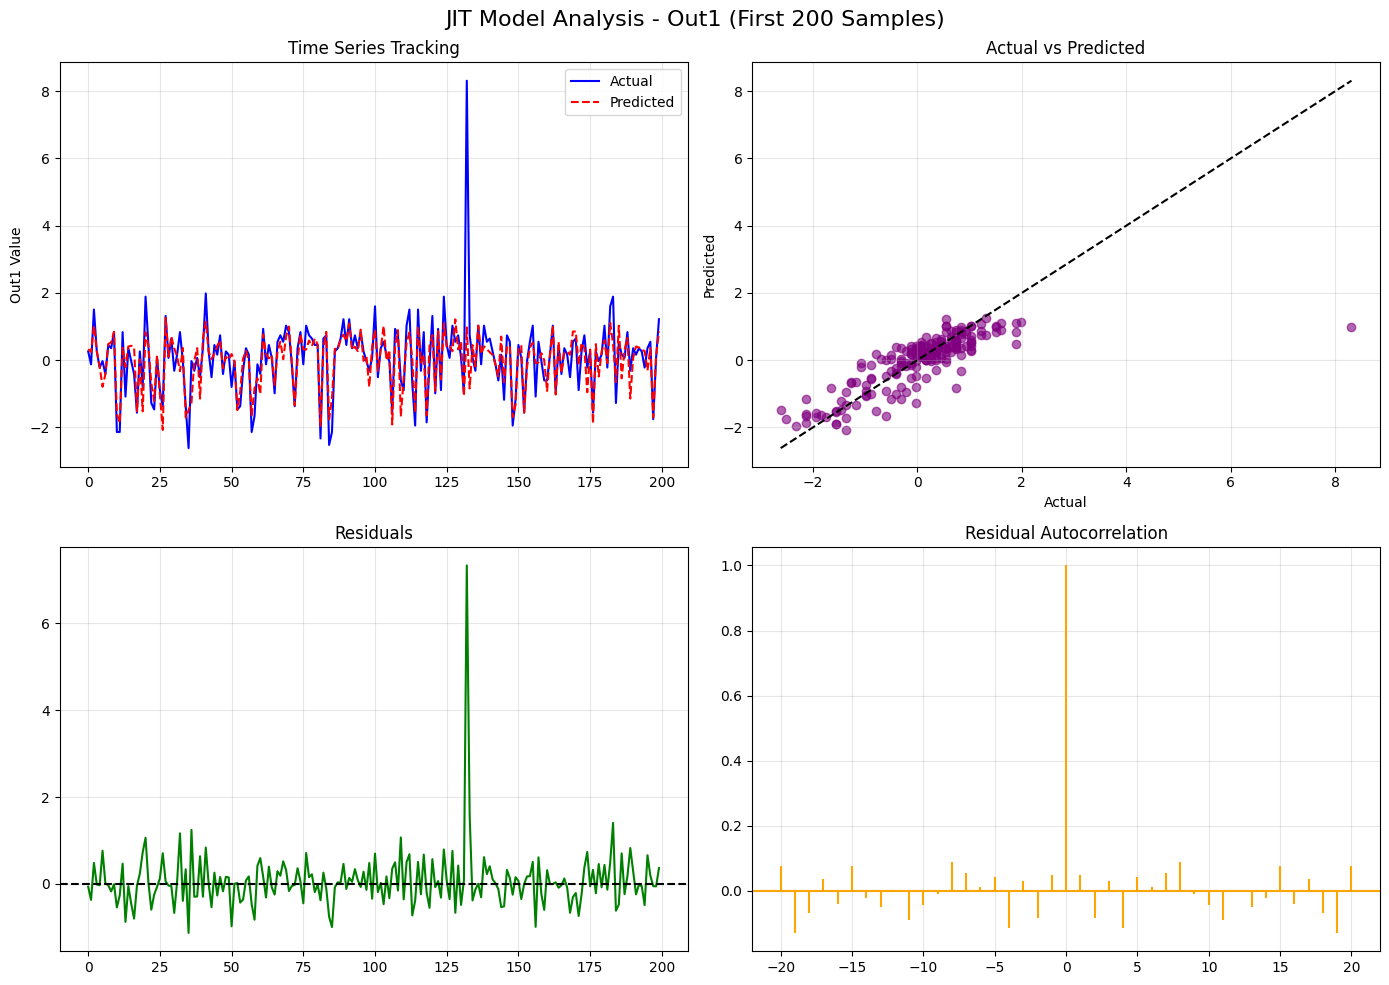

In [8]:
# ============================================================
# CHE512 – JIT SOFT SENSOR (OUTPUT 1 ONLY - 200 SAMPLES)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# ----------------- SETTINGS -----------------
target_name = "Out1"  # <--- CHANGED TO OUT1
N_LIMIT = 200         # <--- LIMIT PROCESSING TO 200 SAMPLES
K_NEIGHBORS = 30      # Number of neighbors for local model

np.random.seed(42)
tf.random.set_seed(42)

# ============================================================
# 1. DATA LOADING & PREPROCESSING
# ============================================================
print(f"Loading data for {target_name} JIT Model...")

# Load datasets (Ensure files are in the same directory)
try:
    df_in = pd.read_csv("IN_Table.csv")
    df_out = pd.read_csv("OUT_Table.csv")
except FileNotFoundError:
    print("Error: IN_Table.csv or OUT_Table.csv not found.")
    exit()

X = df_in.copy()
y = df_out[target_name].copy()

# Split Data (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, shuffle=True, random_state=42
)

# ----------------- Feature Selection (Correlation) -----------------
# We select the top 5 features most correlated with Out1 in the training set
df_temp = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
corr = df_temp.corr()[target_name].drop(target_name)
selected_feats = corr.abs().nlargest(5).index.tolist()

print(f"Selected Features for Local Models ({target_name}): {selected_feats}")

# Filter and Scale Data
X_train_sel = X_train[selected_feats]
X_test_sel = X_test[selected_feats]

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_sel)
X_test_s = scaler.transform(X_test_sel)

# ============================================================
# 2. JIT (LOCAL LEARNING) LOOP - LIMITED TO 200 SAMPLES
# ============================================================
# We limit the loop to the first N_LIMIT samples
n_run = min(N_LIMIT, X_test_s.shape[0])

print(f"\nStarting JIT Loop for first {n_run} test samples only...")
print(f"Configuration: k={K_NEIGHBORS}, Local Model=Small NN")

# Initialize Nearest Neighbors Search
nn_search = NearestNeighbors(n_neighbors=K_NEIGHBORS, metric="euclidean")
nn_search.fit(X_train_s)

y_test_pred_jit = []

# Loop through the LIMITED number of samples
for i in range(n_run):
    # Progress indicator every 20 samples
    if i % 20 == 0:
        print(f"Processing sample {i}/{n_run}...")

    # 1. Identify the Query Sample
    x_query = X_test_s[i:i+1] # Shape (1, n_features)

    # 2. Find Neighbors in Training Data
    distances, indices = nn_search.kneighbors(x_query, return_distance=True)
    idx_neighbors = indices[0]

    # 3. Extract Local Training Data
    X_local = X_train_s[idx_neighbors]
    y_local = y_train.iloc[idx_neighbors].values

    # 4. Build & Train Local Model (Small Neural Net)
    # Since we have few data points (k=30), we use a small, simple network
    model_local = Sequential()
    model_local.add(Dense(32, activation="relu", input_shape=(X_local.shape[1],)))
    model_local.add(Dense(1)) # Linear output

    # Fast compilation and training
    model_local.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mse")

    # We turn off verbosity to keep console clean
    model_local.fit(
        X_local,
        y_local,
        epochs=100,
        batch_size=K_NEIGHBORS,
        verbose=0
    )

    # 5. Predict for the Query Sample
    pred = model_local.predict(x_query, verbose=0)[0, 0]
    y_test_pred_jit.append(pred)

print("JIT Loop Complete.")

# ============================================================
# 3. EVALUATION & PLOTTING
# ============================================================
# Slice the actual Test Data to match the number of samples we processed (200)
y_test_np = y_test.values[:n_run]
y_pred_np = np.array(y_test_pred_jit)

# Metrics
r2 = r2_score(y_test_np, y_pred_np)
rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
residuals = y_test_np - y_pred_np
sse = np.sum(residuals**2)

print(f"\n{'='*40}")
print(f" JIT RESULTS (First {n_run} Samples): {target_name}")
print(f"{'='*40}")
print(f" Test R2 : {r2:.4f}")
print(f" RMSE    : {rmse:.4f}")
print(f" SSE     : {sse:.2f}")

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f"JIT Model Analysis - {target_name} (First {n_run} Samples)", fontsize=16)

# A: Time Series
axes[0, 0].plot(y_test_np, label="Actual", color='blue')
axes[0, 0].plot(y_pred_np, '--', label="Predicted", color='red')
axes[0, 0].set_title("Time Series Tracking")
axes[0, 0].set_ylabel(f"{target_name} Value")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# B: Scatter
axes[0, 1].scatter(y_test_np, y_pred_np, alpha=0.6, color='purple')
mn, mx = min(y_test_np.min(), y_pred_np.min()), max(y_test_np.max(), y_pred_np.max())
axes[0, 1].plot([mn, mx], [mn, mx], 'k--')
axes[0, 1].set_title("Actual vs Predicted")
axes[0, 1].set_xlabel("Actual")
axes[0, 1].set_ylabel("Predicted")
axes[0, 1].grid(True, alpha=0.3)

# C: Residuals
axes[1, 0].plot(residuals, color='green')
axes[1, 0].axhline(0, color='black', linestyle='--')
axes[1, 0].set_title("Residuals")
axes[1, 0].grid(True, alpha=0.3)

# D: Auto-correlation
resid_centered = residuals - np.mean(residuals)
axes[1, 1].acorr(resid_centered, maxlags=20, usevlines=True, color='orange')
axes[1, 1].set_title("Residual Autocorrelation")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
filename = f"JIT_Analysis_{target_name}_200samples.png"
plt.savefig(filename)
print(f"Plot saved to: {filename}")
plt.show()

Loading data for Out2 JIT Model...
Selected Features for Local Models: [' IN3', 'IN1', ' IN4', ' IN2', ' IN5']

Starting JIT Loop for first 200 test samples only...
Configuration: k=30, Local Model=Small NN
Processing sample 0/200...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Processing sample 20/200...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Processing sample 40/200...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Processing sample 60/200...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Processing sample 80/200...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Processing sample 100/200...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Processing sample 120/200...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Processing sample 140/200...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Processing sample 160/200...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Processing sample 180/200...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

JIT Loop Complete.

 JIT RESULTS (First 200 Samples): Out2
 Test R2 : 0.4154
 RMSE    : 0.6456
 SSE     : 83.36


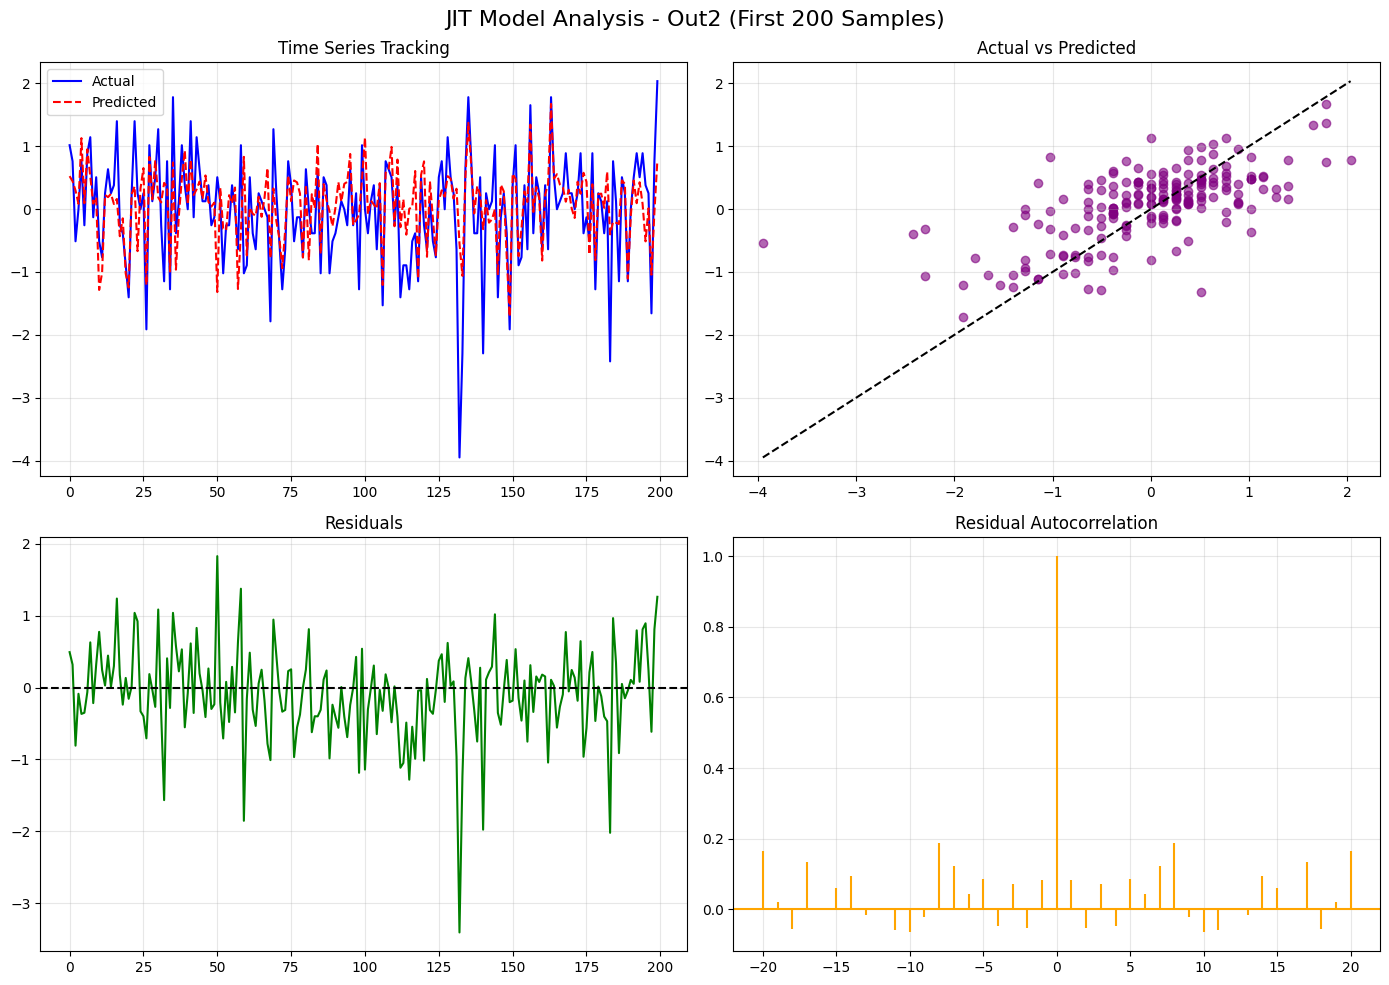

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


target_name = "Out2"
N_LIMIT = 200     # <--- LIMIT PROCESSING TO 200 SAMPLES
K_NEIGHBORS = 30  # Number of neighbors for local model

np.random.seed(42)
tf.random.set_seed(42)


# 1. DATA LOADING & PREPROCESSING

print(f"Loading data for {target_name} JIT Model...")

df_in = pd.read_csv("IN_Table.csv")
df_out = pd.read_csv("OUT_Table.csv")

X = df_in.copy()
y = df_out[target_name].copy()

# Split Data (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, shuffle=True, random_state=42
)

# Feature Selection (Correlation)
# We select the top 5 features most correlated with Out2 in the training set
df_temp = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
corr = df_temp.corr()[target_name].drop(target_name)
selected_feats = corr.abs().nlargest(5).index.tolist()

print(f"Selected Features for Local Models: {selected_feats}")

# Filter and Scale Data
X_train_sel = X_train[selected_feats]
X_test_sel = X_test[selected_feats]

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_sel)
X_test_s = scaler.transform(X_test_sel)


# 2. JIT (LOCAL LEARNING) LOOP - LIMITED TO 200 SAMPLES

# We limit the loop to the first N_LIMIT samples
n_run = min(N_LIMIT, X_test_s.shape[0])

print(f"\nStarting JIT Loop for first {n_run} test samples only...")
print(f"Configuration: k={K_NEIGHBORS}, Local Model=Small NN")

# Initialize Nearest Neighbors Search
nn_search = NearestNeighbors(n_neighbors=K_NEIGHBORS, metric="euclidean")
nn_search.fit(X_train_s)

y_test_pred_jit = []

# Loop through the LIMITED number of samples
for i in range(n_run):
    # Progress indicator every 20 samples
    if i % 20 == 0:
        print(f"Processing sample {i}/{n_run}...")

    # 1. Identify the Query Sample
    x_query = X_test_s[i:i+1] # Shape (1, n_features)

    # 2. Find Neighbors in Training Data
    distances, indices = nn_search.kneighbors(x_query, return_distance=True)
    idx_neighbors = indices[0]

    # 3. Extract Local Training Data
    X_local = X_train_s[idx_neighbors]
    y_local = y_train.iloc[idx_neighbors].values

    # 4. Build & Train Local Model (Small Neural Net)
    # Since we have few data points (k=30), we use a small, simple network
    model_local = Sequential()
    model_local.add(Dense(32, activation="relu", input_shape=(X_local.shape[1],)))
    model_local.add(Dense(1)) # Linear output

    # Fast compilation and training
    model_local.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mse")

    # We turn off verbosity to keep console clean
    model_local.fit(
        X_local,
        y_local,
        epochs=100,
        batch_size=K_NEIGHBORS,
        verbose=0
    )

    # 5. Predict for the Query Sample
    pred = model_local.predict(x_query, verbose=0)[0, 0]
    y_test_pred_jit.append(pred)

print("JIT Loop Complete.")


# 3. EVALUATION & PLOTTING

# Slice the actual Test Data to match the number of samples we processed (200)
y_test_np = y_test.values[:n_run]
y_pred_np = np.array(y_test_pred_jit)

# Metrics
r2 = r2_score(y_test_np, y_pred_np)
rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
residuals = y_test_np - y_pred_np
sse = np.sum(residuals**2)

print(f"\n{'='*40}")
print(f" JIT RESULTS (First {n_run} Samples): {target_name}")
print(f"{'='*40}")
print(f" Test R2 : {r2:.4f}")
print(f" RMSE    : {rmse:.4f}")
print(f" SSE     : {sse:.2f}")

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f"JIT Model Analysis - {target_name} (First {n_run} Samples)", fontsize=16)

# A: Time Series
axes[0, 0].plot(y_test_np, label="Actual", color='blue')
axes[0, 0].plot(y_pred_np, '--', label="Predicted", color='red')
axes[0, 0].set_title("Time Series Tracking")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# B: Scatter
axes[0, 1].scatter(y_test_np, y_pred_np, alpha=0.6, color='purple')
mn, mx = min(y_test_np.min(), y_pred_np.min()), max(y_test_np.max(), y_pred_np.max())
axes[0, 1].plot([mn, mx], [mn, mx], 'k--')
axes[0, 1].set_title("Actual vs Predicted")
axes[0, 1].grid(True, alpha=0.3)

# C: Residuals
axes[1, 0].plot(residuals, color='green')
axes[1, 0].axhline(0, color='black', linestyle='--')
axes[1, 0].set_title("Residuals")
axes[1, 0].grid(True, alpha=0.3)

# D: Auto-correlation
resid_centered = residuals - np.mean(residuals)
axes[1, 1].acorr(resid_centered, maxlags=20, usevlines=True, color='orange')
axes[1, 1].set_title("Residual Autocorrelation")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"JIT_Analysis_{target_name}_200samples.png")
plt.show()